## DOWNLOAD THE 25 MILLION DATASET

In [1]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [4]:
!wget -O moviedataset.zip https://files.grouplens.org/datasets/movielens/ml-25m.zip
print('unziping ...')
!unzip -o -j moviedataset.zip

--2024-05-18 11:02:19--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘moviedataset.zip’

moviedataset.zip    100%[===================>] 249.84M  4.17MB/s    in 85s     

2024-05-18 11:03:44 (2.95 MB/s) - ‘moviedataset.zip’ saved [261978986/261978986]

unziping ...
Archive:  moviedataset.zip
  inflating: tags.csv                
  inflating: links.csv               
  inflating: README.txt              
  inflating: ratings.csv             
  inflating: genome-tags.csv         
  inflating: genome-scores.csv       
  inflating: movies.csv              


In [5]:
#Load the necessary Library
import pandas as pd

from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## LOAD THE DATASET INTO PANDAS DATAFRAME

In [6]:
movies_df = pd.read_csv('movies.csv')

ratings_df = pd.read_csv('ratings.csv')

In [7]:
ratings_df = ratings_df.drop('timestamp', axis=1)
ratings_df.head()

,userId,movieId,rating
0,1,296,5.0
1,1,306,3.5
2,1,307,5.0
3,1,665,5.0
4,1,899,3.5


In [8]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## DATA PREPROCESSING

### ENCODE THE GENRE AS FEATURE VECTORS AND SAVE AS AN ARRAY

In [9]:
def get_unique_genres(genre_string):
    genres = genre_string.split('|')
    return genres

# Apply the function to the DataFrame and get unique genres
unique_genres = set(movies_df['genres'].apply(get_unique_genres).explode())

print(unique_genres)

{'Comedy', 'Crime', 'Thriller', 'Drama', 'Musical', 'Western', 'Action', '(no genres listed)', 'Romance', 'Sci-Fi', 'Documentary', 'IMAX', 'Adventure', 'Mystery', 'War', 'Horror', 'Animation', 'Fantasy', 'Film-Noir', 'Children'}


In [10]:
# Define a function to encode genres
def encode_genres(genre_string):
    genres = genre_string.split('|')
    encoding = [0] * 20  # Assuming there are 5 predefined genres
    # genre_map = {'Mystery', 'Western', 'Comedy', 'Sci-Fi', 'Crime', '(no genres listed)', 'Action', 'Adventure', 'Fantasy', 'Children', 'Documentary', 'Romance', 'Musical', 'Drama', 'Horror', 'Animation', 'Film-Noir', 'War', 'Thriller', 'IMAX'}
    genre_map = {'Mystery':0, 'Western':1, 'Comedy':2, 'Sci-Fi':3, 'Crime':4, '(no genres listed)':5, 'Action':6, 'Adventure':7, 'Fantasy':8, 'Children':9, 'Documentary':10, 'Romance':11, 'Musical':12, 'Drama':13, 'Horror':14, 'Animation':15, 'Film-Noir':16, 'War':17, 'Thriller':18, 'IMAX':19}

    for genre in genres:
        if genre in genre_map:
            encoding[genre_map[genre]] = 1
    return encoding

# Apply the function to the DataFrame
movies_df['features'] = movies_df['genres'].apply(encode_genres)

In [11]:
movies = ratings_df["movieId"].unique().tolist()
users = ratings_df["userId"].unique().tolist()

In [12]:
idx_to_movieid = [movies[i] for i in range(len(movies))]
idx_to_userid = [users[i] for i in range(len(users))]

In [13]:
# Create dictionaries with values as the index in the list
movieid_to_idx = {movie: index for index, movie in enumerate(movies)}
userid_to_idx = {user: index for index, user in enumerate(users)}

In [14]:
ratings_df['user_index'] = ratings_df['userId'].map(userid_to_idx)
ratings_df['movie_index'] = ratings_df['movieId'].map(movieid_to_idx)

In [15]:
ratings_df.head()

,userId,movieId,rating,user_index,movie_index
0,1,296,5.0,0,0
1,1,306,3.5,0,1
2,1,307,5.0,0,2
3,1,665,5.0,0,3
4,1,899,3.5,0,4


In [16]:
movies_df['movie_index'] = movies_df['movieId'].map(movieid_to_idx)

In [17]:
movies_df = movies_df.dropna(subset=['movie_index'])
movies_df['movie_index'] = movies_df['movie_index'].astype(int)


In [18]:
index_to_features = {}

# Iterate through the DataFrame and populate the dictionary
for index, row in movies_df.iterrows():
    movie_index = row['movie_index']
    features = row['features']
    index_to_features[movie_index] = features

# Display the resulting dictionary
print(index_to_features[267])


[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


In [19]:
#change the dictionary to an array for multi-indexing during training

max_index = max(index_to_features.keys())

# Initialize an array filled with zeros
feature_vectors = np.zeros((max_index + 1, len(index_to_features[70])))

# Iterate through the dictionary and update the array at the corresponding index
for index, features in index_to_features.items():
    feature_vectors[index] = features

# Let us access the same index as in the dictionary above and see if we get the same feature embeddings
print(feature_vectors[267,:])


[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [20]:
movies_df.head()

,movieId,title,genres,features,movie_index
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ...",70
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ...",1103
2,3,Grumpier Old Men (1995),Comedy|Romance,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1017
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ...",4270
4,5,Father of the Bride Part II (1995),Comedy,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1858


## EXPLORATORY DATA ANALYSIS (EDA)

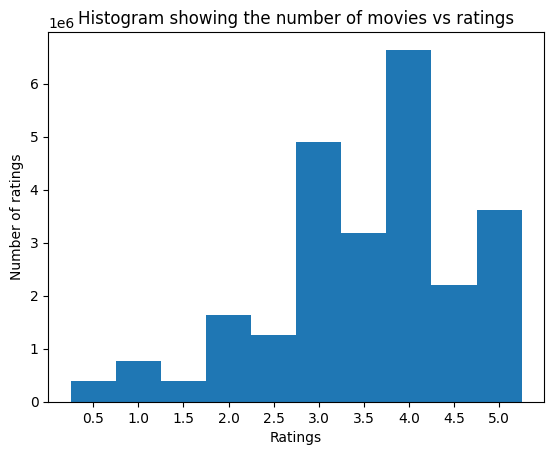

In [18]:

plt.bar(ratings_df['rating'].value_counts().index, height=ratings_df['rating'].value_counts(), width=0.5, align='center')
plt.xticks(ratings_df['rating'].value_counts().index)
plt.title('Histogram showing the number of movies vs ratings')
plt.xlabel('Ratings')
plt.ylabel('Number of ratings')
# plt.show()
filename = 'ratings_distribution.pdf'
plt.savefig(filename, bbox_inches='tight')

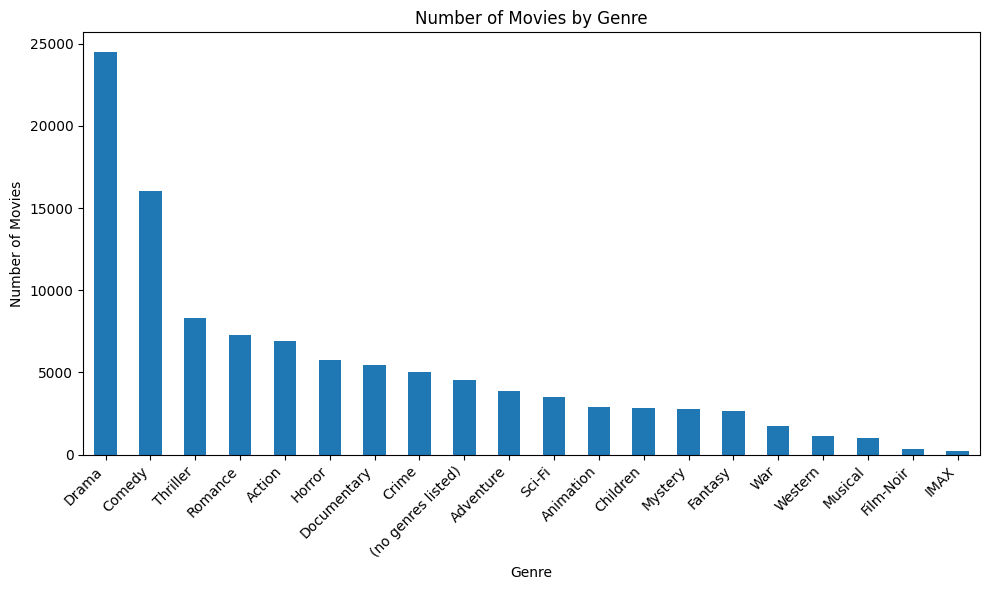

In [19]:

# Split genres and create a list of all genres
all_genres = '|'.join(movies_df['genres']).split('|')

# Count occurrences of each genre
genre_counts = pd.Series(all_genres).value_counts()

# Plot histogram
plt.figure(figsize=(10,6))
genre_counts.plot(kind='bar')
plt.title('Number of Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
# plt.show()
filename = 'Number_of_movies_by_genre.pdf'
plt.savefig(filename, bbox_inches='tight')


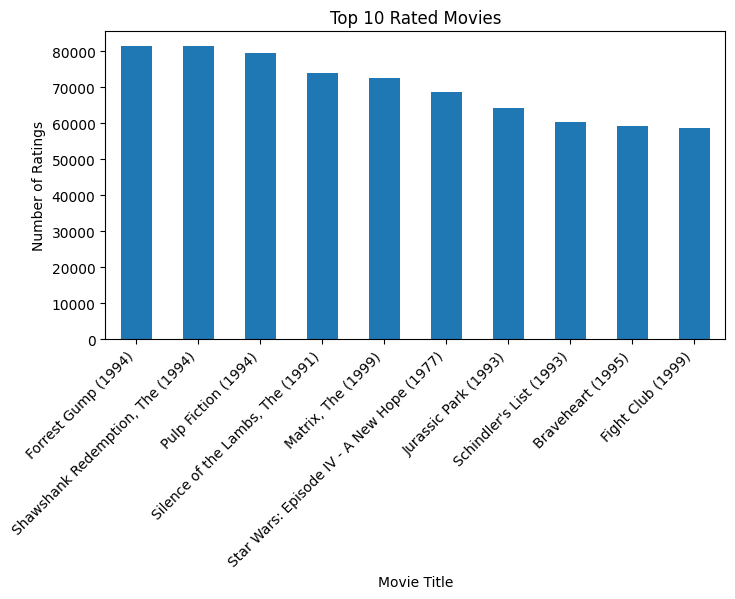

In [20]:
# Merge ratings_df with movies_df to get movie names
merged_df = pd.merge(ratings_df, movies_df, on='movieId')

# Count the number of ratings for each movie
movie_ratings_counts = merged_df['title'].value_counts()

# Get the top 10 rated movies
top_10_rated_movies = movie_ratings_counts.head(10)

# Plot histogram
plt.figure(figsize=(8,4))
top_10_rated_movies.plot(kind='bar')
plt.title('Top 10 Rated Movies')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()
filename = 'Top_10_Rated_movies.pdf'
plt.savefig(filename, bbox_inches='tight')

In [21]:
def plot_rating():
    user_rating_counts = ratings_df.groupby('userId')['rating'].count()
    df = ratings_df.sort_values(by=['movieId'])
    movie_rating_counts = df.groupby('movieId')['rating'].count()

    user_degrees = user_rating_counts.value_counts().sort_index()
    movie_degrees = movie_rating_counts.value_counts().sort_index()

    plt.figure(figsize=(10, 5))
    plt.scatter(user_degrees.index, user_degrees.values, color='blue', alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Ratings per User (log scale)')
    plt.ylabel('Number of Users (log scale)')
    plt.title('Distribution of User Ratings')
    plt.grid(True)
    # plt.show()
    filename = 'user_ratings_power_law.pdf'
    plt.savefig(filename, bbox_inches='tight')

    plt.figure(figsize=(10, 5))
    plt.scatter(movie_degrees.index, movie_degrees.values, color='green', alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of Ratings per Movie (log scale)')
    plt.ylabel('Number of Movies (log scale)')
    plt.title('Distribution of Movie Ratings')
    plt.grid(True)
    # plt.show()
    filename = 'item_ratings_power_law.pdf'
    plt.savefig(filename, bbox_inches='tight')


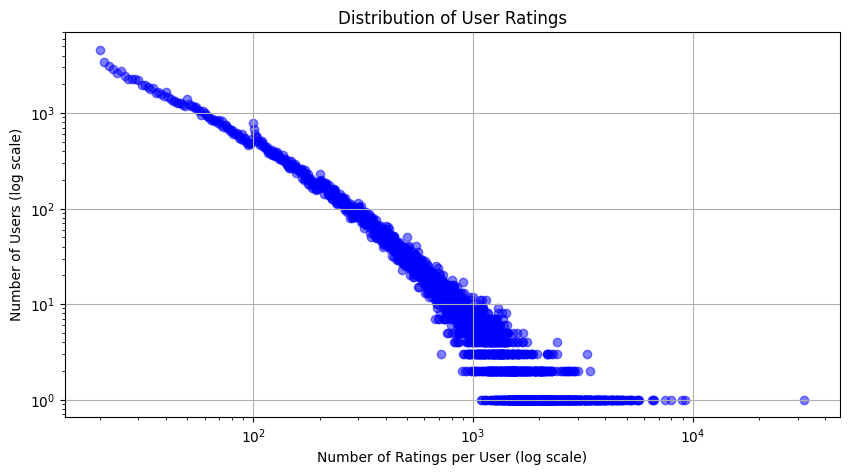

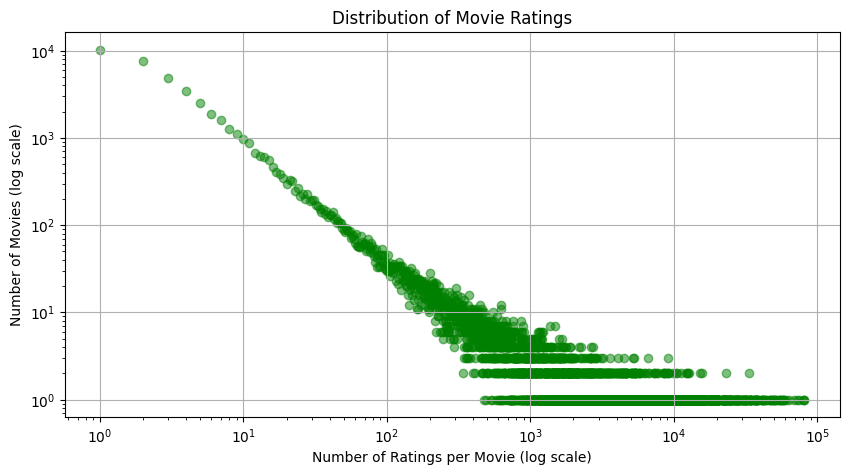

In [22]:
plot_rating()

## CHANGE DATA STRUCTURE TO DESIRED FORMAT (LIST OF ARRAYS OF TUPLES)

In [21]:
user_ids = ratings_df['userId'].tolist()
movie_ids = ratings_df['movieId'].tolist()
ratings = ratings_df['rating'].tolist()

In [22]:

user_data_list = [[] for _ in range(ratings_df["userId"].nunique())]
movie_data_list = [[] for _ in range(ratings_df["movieId"].nunique())]


for user_id, movie_id, rating in zip(user_ids, movie_ids, ratings):
    user_data_list[userid_to_idx[user_id]].append((movieid_to_idx[movie_id], rating))
    movie_data_list[movieid_to_idx[movie_id]].append((userid_to_idx[user_id], rating))


print("Length of user_data_list:", len(user_data_list))

print("Length of movie_data_list:", len(movie_data_list))



Length of user_data_list: 162541
Length of movie_data_list: 59047


In [23]:
user_data_list = [np.array(sublist) for sublist in user_data_list]
movie_data_list = [np.array(sublist) for sublist in movie_data_list]

## TRAIN THE BIASES ONLY MODEL

In [ ]:
from tqdm.notebook import tqdm

M = len(user_data_list)
N = len(movie_data_list)
k = 10
user_biases = np.zeros((M))
item_biases = np.zeros((N))
iter = 100
lbda = 1
gamma = 0.0001
losses=[]
errors=[]



for i in tqdm(range(iter)):
    for m in range(M):
      if len(user_data_list[m]) > 0:
        ratings = user_data_list[m][:, 1]
        indices = user_data_list[m][:, 0].astype(int)

        # Calculate user bias
        user_bias = lbda * np.sum(ratings - item_biases[indices]) / (lbda * len(indices) + gamma)
        user_biases[m] = user_bias

    for q in range(N):
      if len(movie_data_list) > 0:
        ratings = movie_data_list[q][:, 1]
        indices = movie_data_list[q][:, 0].astype(int)
        # Calculate user bias
        item_bias = lbda * np.sum(ratings - user_biases[indices]) / (lbda * len(indices) + gamma)
        item_biases[q] = item_bias

    # Calculate training loss and RMSE
    train_error_squared = 0
    train_size = 0

    for m in range(M):
      if len(user_data_list[m]) > 0:
          train_ratings = user_data_list[m][:, 1]
          train_indices = user_data_list[m][:, 0].astype(int)
          train_error_squared += np.sum((train_ratings - user_biases[m] - item_biases[train_indices])**2)
          train_size += len(train_indices)

    train_loss = -0.5 * lbda * train_error_squared - 0.5 * gamma * (np.sum(user_biases**2) + np.sum(item_biases**2))
    train_error = np.sqrt(1 / train_size * train_error_squared)

    losses.append(-train_loss)
    errors.append(train_error)


  0%|          | 0/100 [00:00<?, ?it/s]

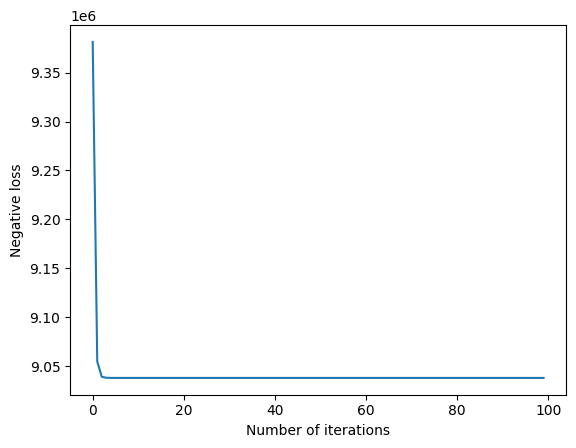

In [ ]:
plt.plot(losses)
plt.xlabel('Number of iterations')
plt.ylabel('Negative loss')
# plt.title('Negative regularized log likelihood loss for biases only')
filename = 'Neg_regularized_log_likelihood_loss1.pdf'
plt.savefig(filename, bbox_inches='tight')

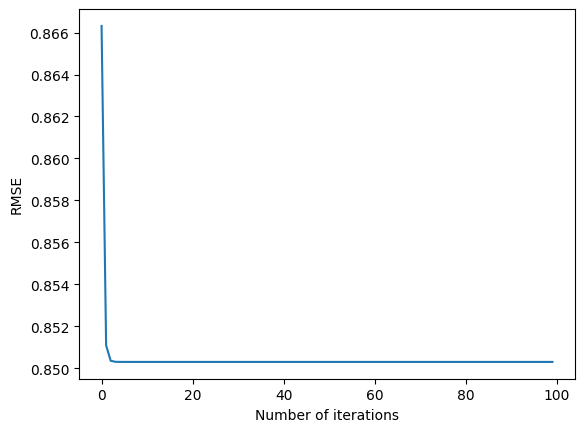

In [ ]:
plt.plot(errors)
plt.xlabel('Number of iterations')
plt.ylabel('RMSE')
# plt.title('RMSE for biases only')
filename = 'Neg_regularized_log_likelihood_rmse1.pdf'
plt.savefig(filename, bbox_inches='tight')

## TRAIN BIASES+LATENT VCETORS MODEL FOR K=10 and k=20

In [32]:
from tqdm.notebook import tqdm

M = len(user_data_list)
N = len(movie_data_list)
k = 10
user_biases = np.zeros((M))
item_biases = np.zeros((N))
user_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(M,k))
item_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(N,k))
iter = 100
lbda = 1
gamma = 0.001
tau = 1
losses_k10=[]
errors_k10=[]



for i in tqdm(range(iter)):
    for m in range(M):
      if len(user_data_list[m]) > 0:
        ratings = user_data_list[m][:, 1]
        indices = user_data_list[m][:, 0].astype(int)

        # Calculate user bias
        user_bias = lbda * np.sum(ratings - item_biases[indices]) / (lbda * len(indices) + gamma)
        user_biases[m] = user_bias

        # Calculate left and right matrices for user factor update
        left = np.sum(np.einsum('ij,il->ijl', item_latent_vectors[indices], item_latent_vectors[indices]), axis=0)
        right = np.sum(np.einsum('ji,j->ji', item_latent_vectors[indices], ratings - user_bias - item_biases[indices]), axis=0)

        # Update user factor
        user_latent_vectors[m] = np.linalg.solve(lbda * left + tau * np.eye(k), lbda * right)

    for q in range(N):
      if len(movie_data_list) > 0:
        ratings = movie_data_list[q][:, 1]
        indices = movie_data_list[q][:, 0].astype(int)

        # Calculate user bias
        item_bias = lbda * np.sum(ratings - user_biases[indices]) / (lbda * len(indices) + gamma)
        item_biases[q] = item_bias

        # Calculate left and right matrices for item factor update
        left = np.sum(np.einsum('ij,il->ijl', user_latent_vectors[indices], user_latent_vectors[indices]), axis=0)
        right = np.sum(np.einsum('ji,j->ji', user_latent_vectors[indices], ratings - user_biases[indices] - item_bias), axis=0)

        # Update item factor
        item_latent_vectors[q] = np.linalg.solve(lbda * left + tau * np.eye(k), lbda * right)

    # Calculate training loss and RMSE
    error_squared = 0
    train_size = 0

    for m in range(M):
      if len(user_data_list[m]) > 0:
          ratings = user_data_list[m][:, 1]
          indices = user_data_list[m][:, 0].astype(int)
          error_squared += np.sum((ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[indices]) - user_biases[m] - item_biases[indices])**2)
          train_size += len(indices)


    loss = -0.5 * lbda * error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij,ij->', item_latent_vectors, item_latent_vectors) + np.einsum('ij,ij->', user_latent_vectors, user_latent_vectors))
    error = np.sqrt(1 / train_size * error_squared)

    losses_k10.append(-loss)
    errors_k10.append(error)


  0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
from tqdm.notebook import tqdm

M = len(user_data_list)
N = len(movie_data_list)
k = 20
user_biases = np.zeros((M))
item_biases = np.zeros((N))
user_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(M,k))
item_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(N,k))
iter = 100
lbda = 1
gamma = 0.001
tau = 1
losses_k20=[]
errors_k20=[]



for i in tqdm(range(iter)):
    for m in range(M):
      if len(user_data_list[m]) > 0:
        ratings = user_data_list[m][:, 1]
        indices = user_data_list[m][:, 0].astype(int)

        # Calculate user bias
        user_bias = lbda * np.sum(ratings - item_biases[indices]) / (lbda * len(indices) + gamma)
        user_biases[m] = user_bias

        # Calculate left and right matrices for user factor update
        left = np.sum(np.einsum('ij,il->ijl', item_latent_vectors[indices], item_latent_vectors[indices]), axis=0)
        right = np.sum(np.einsum('ji,j->ji', item_latent_vectors[indices], ratings - user_bias - item_biases[indices]), axis=0)

        # Update user factor
        user_latent_vectors[m] = np.linalg.solve(lbda * left + tau * np.eye(k), lbda * right)

    for q in range(N):
      if len(movie_data_list) > 0:
        ratings = movie_data_list[q][:, 1]
        indices = movie_data_list[q][:, 0].astype(int)

        # Calculate user bias
        item_bias = lbda * np.sum(ratings - user_biases[indices]) / (lbda * len(indices) + gamma)
        item_biases[q] = item_bias

        # Calculate left and right matrices for item factor update
        left = np.sum(np.einsum('ij,il->ijl', user_latent_vectors[indices], user_latent_vectors[indices]), axis=0)
        right = np.sum(np.einsum('ji,j->ji', user_latent_vectors[indices], ratings - user_biases[indices] - item_bias), axis=0)

        # Update item factor
        item_latent_vectors[q] = np.linalg.solve(lbda * left + tau * np.eye(k), lbda * right)

    # Calculate training loss and RMSE
    error_squared = 0
    train_size = 0

    for m in range(M):
      if len(user_data_list[m]) > 0:
          ratings = user_data_list[m][:, 1]
          indices = user_data_list[m][:, 0].astype(int)
          error_squared += np.sum((ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[indices]) - user_biases[m] - item_biases[indices])**2)
          train_size += len(indices)


    loss = -0.5 * lbda * error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij,ij->', item_latent_vectors, item_latent_vectors) + np.einsum('ij,ij->', user_latent_vectors, user_latent_vectors))
    error = np.sqrt(1 / train_size * error_squared)

    losses_k20.append(-loss)
    errors_k20.append(error)


  0%|          | 0/100 [00:00<?, ?it/s]

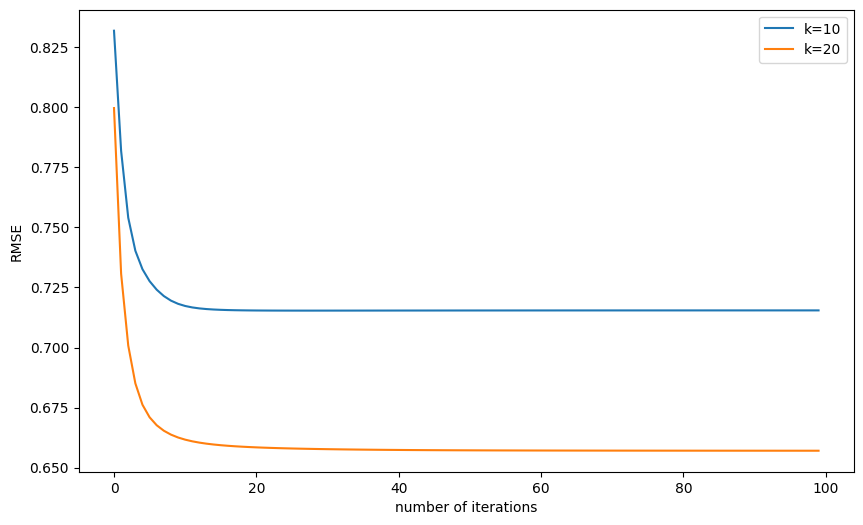

In [ ]:
# Create a plot
plt.figure(figsize=(10, 6))

# Plot each loss list
plt.plot(errors_k10, label='k=10')
plt.plot(errors_k20, label='k=20')

# Add titles and labels
# plt.title('Losses for Various Values of k')
plt.xlabel('number of iterations')
plt.ylabel('RMSE')

# Add a legend
plt.legend()

# Show the plot
# plt.show()
filename = 'RMSE_for_various_k_25million.pdf'
plt.savefig(filename, bbox_inches='tight')



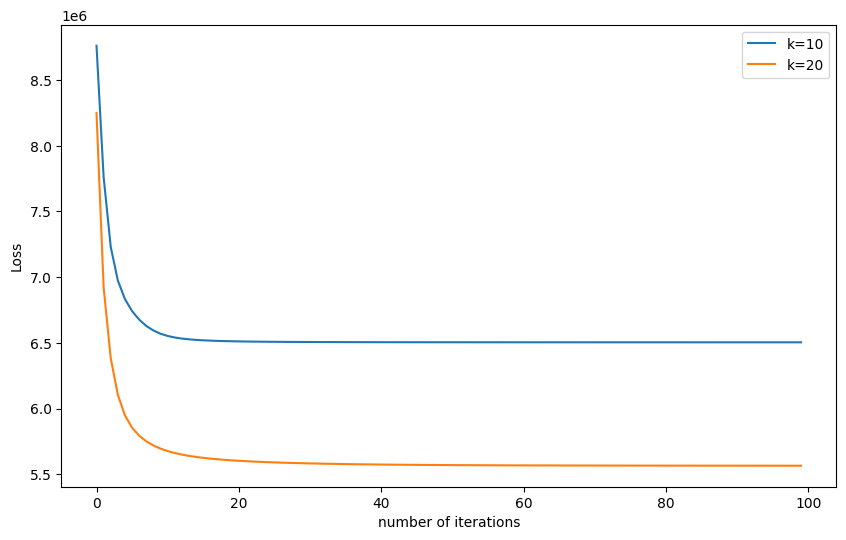

In [ ]:


# Create a plot
plt.figure(figsize=(10, 6))

# Plot each loss list
plt.plot(losses_k10, label='k=10')
plt.plot(losses_k20, label='k=20')

# Add titles and labels
# plt.title('Losses for Various Values of k')
plt.xlabel('number of iterations')
plt.ylabel('Loss')

# Add a legend
plt.legend()

# Show the plot
# plt.show()
filename = 'losses_for_various_k_25million.pdf'
plt.savefig(filename, bbox_inches='tight')



## TRAIN THE BIASES + LATENT VECTORS MODEL FOR k=2 and VISUALIZE THE POLARIZING AND NON-POLARIZING MOVIES AS WELL AS OTHER INFORMATION

In [24]:
from tqdm.notebook import tqdm

M = len(user_data_list)
N = len(movie_data_list)
k = 2
user_biases = np.zeros((M))
item_biases = np.zeros((N))
user_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(M,k))
item_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(N,k))
iter = 100
lbda = 1
gamma = 0.001
tau = 1
losses_k2=[]
errors_k2=[]



for i in tqdm(range(iter)):
    for m in range(M):
      if len(user_data_list[m]) > 0:
        ratings = user_data_list[m][:, 1]
        indices = user_data_list[m][:, 0].astype(int)

        # Calculate user bias
        user_bias = lbda * np.sum(ratings - item_biases[indices]) / (lbda * len(indices) + gamma)
        user_biases[m] = user_bias

        # Calculate left and right matrices for user factor update
        left = np.sum(np.einsum('ij,il->ijl', item_latent_vectors[indices], item_latent_vectors[indices]), axis=0)
        right = np.sum(np.einsum('ji,j->ji', item_latent_vectors[indices], ratings - user_bias - item_biases[indices]), axis=0)

        # Update user factor
        user_latent_vectors[m] = np.linalg.solve(lbda * left + tau * np.eye(k), lbda * right)

    for q in range(N):
      if len(movie_data_list) > 0:
        ratings = movie_data_list[q][:, 1]
        indices = movie_data_list[q][:, 0].astype(int)

        # Calculate user bias
        item_bias = lbda * np.sum(ratings - user_biases[indices]) / (lbda * len(indices) + gamma)
        item_biases[q] = item_bias

        # Calculate left and right matrices for item factor update
        left = np.sum(np.einsum('ij,il->ijl', user_latent_vectors[indices], user_latent_vectors[indices]), axis=0)
        right = np.sum(np.einsum('ji,j->ji', user_latent_vectors[indices], ratings - user_biases[indices] - item_bias), axis=0)

        # Update item factor
        item_latent_vectors[q] = np.linalg.solve(lbda * left + tau * np.eye(k), lbda * right)

    # Calculate training loss and RMSE
    error_squared = 0
    train_size = 0

    for m in range(M):
      if len(user_data_list[m]) > 0:
          ratings = user_data_list[m][:, 1]
          indices = user_data_list[m][:, 0].astype(int)
          error_squared += np.sum((ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[indices]) - user_biases[m] - item_biases[indices])**2)
          train_size += len(indices)


    loss = -0.5 * lbda * error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij,ij->', item_latent_vectors, item_latent_vectors) + np.einsum('ij,ij->', user_latent_vectors, user_latent_vectors))
    error = np.sqrt(1 / train_size * error_squared)

    losses_k2.append(-loss)
    errors_k2.append(error)


  0%|          | 0/100 [00:00<?, ?it/s]

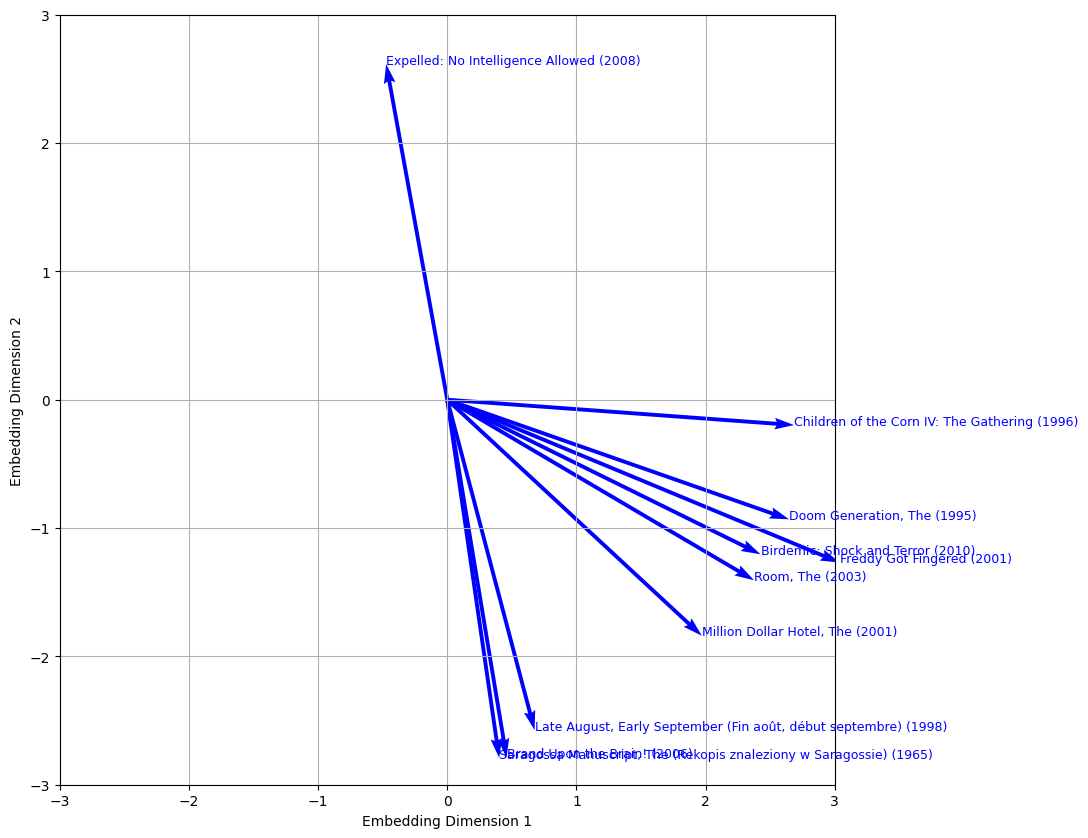

In [25]:

# Calculate Euclidean distances from the origin
distances = np.linalg.norm(item_latent_vectors, axis=1)

# Get the indices of the top 10 and bottom 10 movies
top_10_indices = np.argsort(distances)[-10:]

# Plot the trait vectors
plt.figure(figsize=(10, 10))
plt.quiver(np.zeros(len(top_10_indices)), np.zeros(len(top_10_indices)),
           item_latent_vectors[top_10_indices, 0], item_latent_vectors[top_10_indices, 1],
           angles='xy', scale_units='xy', scale=1, color='b', width=0.005, label='Most Polarizing')


# Add titles for the highlighted movies
for i in top_10_indices:
    plt.text(item_latent_vectors[i, 0], item_latent_vectors[i, 1], movies_df.loc[movies_df['movie_index'] == i, 'title'].values[0], fontsize=9, color='blue')

plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
# plt.title('Polarizing Movies in the Latent Space')
# plt.legend()
plt.grid(True)
# plt.savefig('Figs/polarizing_movies.png')
filename = 'Most_polarizing_movies.pdf'
plt.savefig(filename, bbox_inches='tight')
# plt.show()




In [26]:
    # Initialize a list to store top predictions
    most_polarizing_movies = []

    # Iterate through the sorted movie indices
    for index in top_10_indices:
        most_polarizing_movies.append(movies_df.loc[movies_df['movie_index'] == index, 'title'].iloc[0])
    most_polarizing_movies

['Expelled: No Intelligence Allowed (2008)',
 'Late August, Early September (Fin août, début septembre) (1998)',
 'Children of the Corn IV: The Gathering (1996)',
 'Million Dollar Hotel, The (2001)',
 'Birdemic: Shock and Terror (2010)',
 'Room, The (2003)',
 'Doom Generation, The (1995)',
 'Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)',
 'Brand Upon the Brain! (2006)',
 'Freddy Got Fingered (2001)']

In [27]:
bottom_10_indices = np.argsort(distances)[:10]

least_polarizing_movies = []
# Iterate through the sorted movie indices
for index in bottom_10_indices:
    least_polarizing_movies.append(movies_df.loc[movies_df['movie_index'] == index, 'title'].iloc[0])
least_polarizing_movies

['Overseas and Under Your Skin (Maata meren alla) (2009)',
 'Stupid Young Heart (2018)',
 'I Passed for White (1960)',
 'Refrigerantes e Canções de Amor (2016)',
 'Shit Happens (2000)',
 'Hey Bunny (2017)',
 'Oggi sposi (2009)',
 'Il Bi e il Ba (1986)',
 "The Bride's Journey (1997)",
 'Trance (2001)']

# PLOTTING THE EMBEDDINGS FOR k=2 TO VISUALIZE HOW WELL THE MODEL EMBEDS DISTINCT AND OPPOSITE GENRE

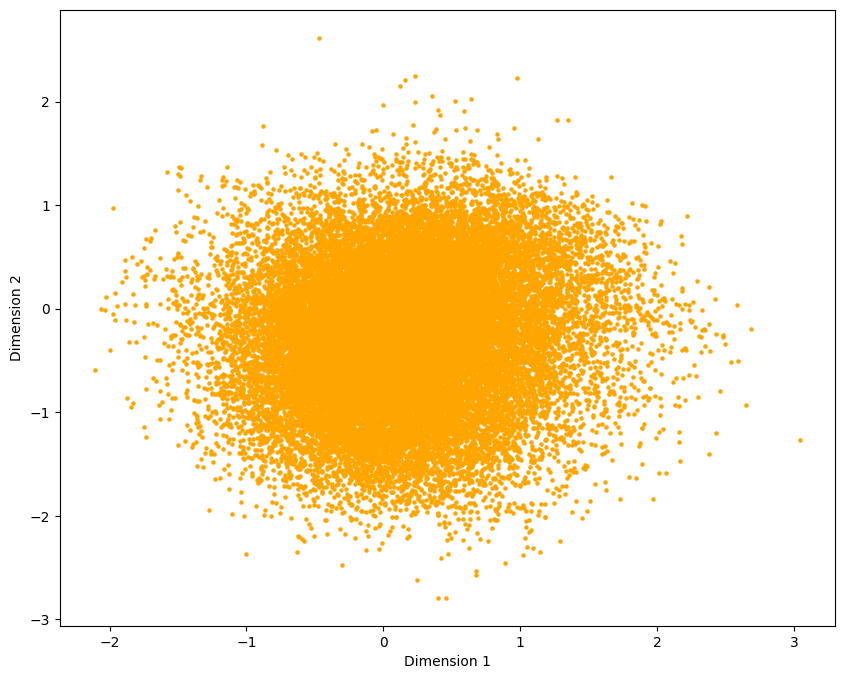

In [28]:

plt.figure(figsize=(10,8))
plt.scatter(item_latent_vectors[:,0], item_latent_vectors[:,1], s=5, c='orange')
# plt.title('2D movies embeddings plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
# plt.show()
filename = 'movies_embeddings_1.pdf'
plt.savefig(filename, bbox_inches='tight')

popular_movies_index = []

for index, movie in enumerate(movie_data_list):
    if len(movie) > 300:
        popular_movies_index.append(index)
popular_movies_embedding = item_latent_vectors[popular_movies_index]



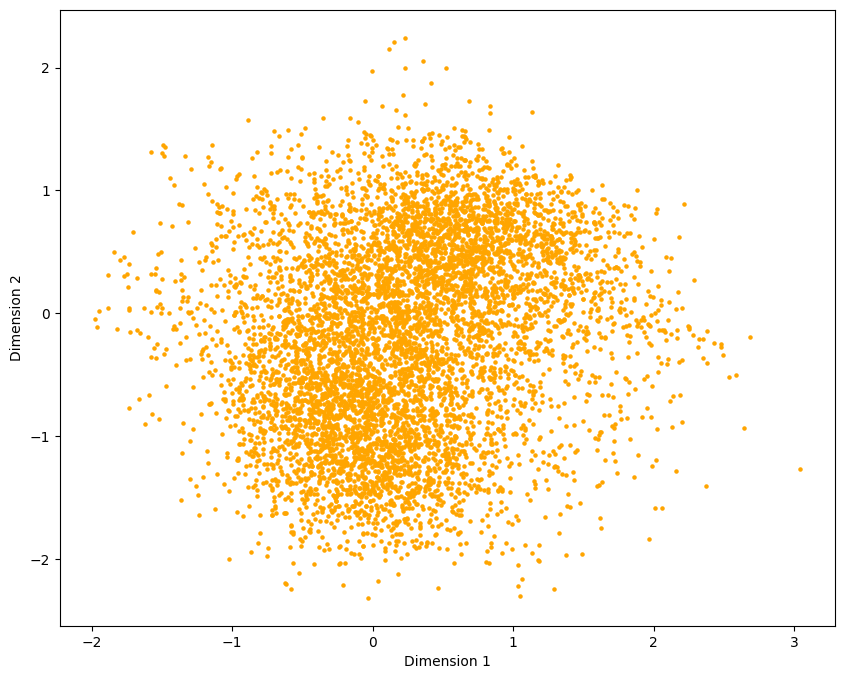

In [29]:
plt.figure(figsize=(10,8))
plt.scatter(popular_movies_embedding[:,0], popular_movies_embedding[:,1], s=5, c='orange')
# plt.title('2D movies embeddings plot for movies with >300 ratings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
# plt.show()
filename = 'movies_embeddings_2.pdf'
plt.savefig(filename, bbox_inches='tight')



In [30]:
genre_index_dict = {}

for index, row in movies_df.iterrows():
    genres = row['genres'].split('|')
    movie_index = row['movie_index']

    for genre in genres:
        if genre in genre_index_dict:
            genre_index_dict[genre].append(movie_index)
        else:
            genre_index_dict[genre] = [movie_index]



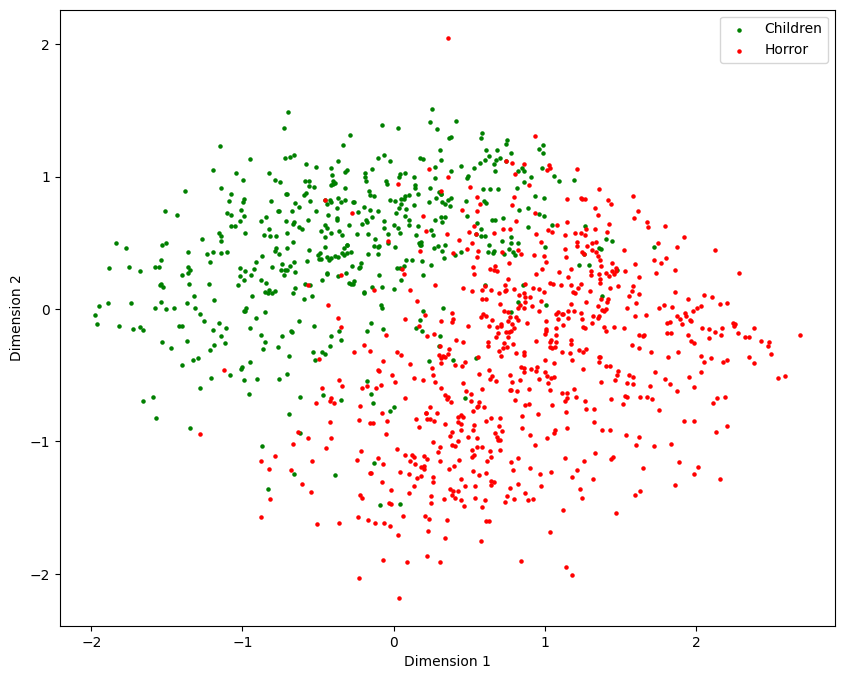

In [31]:
popular_genre_movie_indexes = {}


for genre in unique_genres:
    popular_genre_movie_indexes[genre] = []

    for index in popular_movies_index:
        if index in genre_index_dict[genre]:
            popular_genre_movie_indexes[genre].append(index)

emb1 = item_latent_vectors[popular_genre_movie_indexes['Children']]
emb2 = item_latent_vectors[popular_genre_movie_indexes['Horror']]

plt.figure(figsize=(10,8))
plt.scatter(emb1[:,0], emb1[:,1], s=5, label = 'Children', c = 'green')
plt.scatter(emb2[:,0], emb2[:,1], s=5, label = 'Horror', c = 'red')
plt.legend()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
# plt.title('2D movies embeddings plot of children and horror movies only')
# plt.show()
filename = 'movies_embeddings_3.pdf'
plt.savefig(filename, bbox_inches='tight')

In [ ]:
import pickle

with open('user_biases_k2.pkl', 'wb') as f:
    pickle.dump(user_biases, f)

with open('item_biases_k2.pkl', 'wb') as f:
    pickle.dump(item_biases, f)

with open('user_latent_vectors_k2.pkl', 'wb') as f:
    pickle.dump(user_latent_vectors, f)

with open('item_latent_vectors_k2.pkl', 'wb') as f:
    pickle.dump(item_latent_vectors, f)

# with open('user_latent_vectors.pkl', 'rb') as f:
#     user_latent_vectors = pickle.load(f)

# with open('item_latent_vectorsf2.pkl', 'rb') as f:
    # item_latent_vectors = pickle.load(f)

# with open('item_biases.pkl', 'rb') as f:
#     item_biases = pickle.load(f)

# with open('user_biases.pkl', 'rb') as f:
#     user_biases = pickle.load(f)

## SPLIT THE DATASET INTO TRAIN AND TEST SET

In [ ]:
key = np.random.default_rng(0)
user_ids = ratings_df['userId'].tolist()
movie_ids = ratings_df['movieId'].tolist()
ratings = ratings_df['rating'].tolist()
train_user_data_list = [[] for _ in range(ratings_df["userId"].nunique())]
test_user_data_list = [[] for _ in range(ratings_df["userId"].nunique())]
train_movie_data_list = [[] for _ in range(ratings_df["movieId"].nunique())]
test_movie_data_list = [[] for _ in range(ratings_df["movieId"].nunique())]

for user_id, movie_id, rating in zip(user_ids, movie_ids, ratings):
  if key.uniform(0, 1) < 0.8:
    train_user_data_list[userid_to_idx[user_id]].append((movieid_to_idx[movie_id], rating))
    train_movie_data_list[movieid_to_idx[movie_id]].append((userid_to_idx[user_id], rating))
  else:
    test_user_data_list[userid_to_idx[user_id]].append((movieid_to_idx[movie_id], rating))
    test_movie_data_list[movieid_to_idx[movie_id]].append((userid_to_idx[user_id], rating))


print("Length of train_user_data_list:", len(train_user_data_list))
print("Length of test_user_data_list:", len(test_user_data_list))
print("Length of train_user_data_list:", len(train_movie_data_list))
print("Length of test_user_data_list:", len(test_movie_data_list))


Length of train_user_data_list: 162541
Length of test_user_data_list: 162541
Length of train_user_data_list: 59047
Length of test_user_data_list: 59047


In [ ]:

train_user_data_list = [np.array(sublist) for sublist in train_user_data_list]
test_user_data_list = [np.array(sublist) for sublist in test_user_data_list]
train_movie_data_list = [np.array(sublist) for sublist in train_movie_data_list]
test_movie_data_list = [np.array(sublist) for sublist in test_movie_data_list]


## TRAIN AND PERFORM EVALUATION WITH THE SPLITTED DATASET FOR VALUES OF k=10 AND k=20

In [ ]:
from tqdm.notebook import tqdm

M = len(train_user_data_list)
N = len(train_movie_data_list)
k=10
user_biases = np.zeros((M))
item_biases = np.zeros((N))
user_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(M,k))
item_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(N,k))
train_losses_k10=[]
test_losses_k10=[]
train_errors_k10=[]
test_errors_k10=[]
iter = 100
lbda = 1
gamma = 0.001
tau = 1

for i in tqdm(range(iter)):
    for m in range(M):
        # Extract ratings and indices for the current user
        if len(train_user_data_list) > 0:
            ratings = train_user_data_list[m][:, 1]
            indices = train_user_data_list[m][:, 0].astype(int)

            # Calculate user bias
            user_bias = lbda * np.sum(ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[indices]) - item_biases[indices]) / (lbda * len(indices) + gamma)
            user_biases[m] = user_bias

            # Calculate left and right matrices for user factor update
            left = np.sum(np.einsum('ij,il->ijl', item_latent_vectors[indices], item_latent_vectors[indices]), axis=0)
            right = np.sum(np.einsum('ji,j->ji', item_latent_vectors[indices], ratings - user_bias - item_biases[indices]), axis=0)

            # Update user factor
            user_latent_vectors[m] = np.linalg.solve(lbda * left + tau * np.eye(k), lbda * right)

    for n in range(N):
        # Extract ratings and indices for the current item
        if len(train_movie_data_list[n]) > 0:
            ratings = train_movie_data_list[n][:, 1]
            indices = train_movie_data_list[n][:, 0].astype(int)

            # Calculate item bias
            item_bias = lbda * np.sum(ratings - np.einsum('ij,j->i', user_latent_vectors[indices], item_latent_vectors[n]) - user_biases[indices]) / (lbda * len(indices) + gamma)
            item_biases[n] = item_bias

            # Calculate left and right matrices for item factor update
            left = np.sum(np.einsum('ij,il->ijl', user_latent_vectors[indices], user_latent_vectors[indices]), axis=0)
            right = np.sum(np.einsum('ji,j->ji', user_latent_vectors[indices], ratings - user_biases[indices] - item_bias), axis=0)

            # Update item factor
            item_latent_vectors[n] = np.linalg.solve(lbda * left + tau * np.eye(k), lbda * right)

    # Calculate training loss and RMSE
    train_error_squared = 0
    train_size = 0
    test_error_squared = 0
    test_size = 0

    for m in range(M):
        if len(train_user_data_list[m]) > 0:
            train_ratings = train_user_data_list[m][:, 1]
            train_indices = train_user_data_list[m][:, 0].astype(int)
            train_error_squared += np.sum((train_ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[train_indices]) - user_biases[m] - item_biases[train_indices])**2)
            train_size += len(train_indices)

        if len(test_user_data_list[m]) > 0:
            test_ratings = test_user_data_list[m][:, 1]
            test_indices = test_user_data_list[m][:, 0].astype(int)
            test_error_squared += np.sum((test_ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[test_indices]) - user_biases[m] - item_biases[test_indices])**2)
            test_size += len(test_indices)

    train_loss = -0.5 * lbda * train_error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij,ij->', item_latent_vectors, item_latent_vectors) + np.einsum('ij,ij->', user_latent_vectors, user_latent_vectors))
    train_error = np.sqrt(1 / train_size * train_error_squared)

    train_losses_k10.append(-train_loss)
    train_errors_k10.append(train_error)

    test_loss = -0.5 * lbda * test_error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij, ij->', item_latent_vectors, item_latent_vectors) + np.einsum('ij, ij->', user_latent_vectors, user_latent_vectors))
    test_error = np.sqrt(1/test_size * test_error_squared)

    test_losses_k10.append(-test_loss)
    test_errors_k10.append(test_error)

    print(f"train loss {round(-train_loss, 2)} test loss {round(-test_loss, 2)} train rmse {train_error} test rmse {test_error}")


  0%|          | 0/100 [00:00<?, ?it/s]

train loss 6931251.57 test loss 2174171.04 train rmse 0.82533758000389 test rmse 0.9069698624360919
train loss 6147440.5 test loss 2015617.33 train rmse 0.7758580426656623 test rmse 0.869323608839514
train loss 5662069.65 test loss 1884950.63 train rmse 0.7437260995828753 test rmse 0.838002922239182
train loss 5415580.38 test loss 1816272.05 train rmse 0.7268920875457607 test rmse 0.8211717725690525
train loss 5284203.28 test loss 1777849.86 train rmse 0.7178197385993232 test rmse 0.811827664218747
train loss 5206075.45 test loss 1754233.17 train rmse 0.7124240766475601 test rmse 0.8062210416957478
train loss 5155322.35 test loss 1738534.82 train rmse 0.7089392406349962 test rmse 0.8026184651344398
train loss 5120222.99 test loss 1727430.29 train rmse 0.7065522591377243 test rmse 0.8001724425230522
train loss 5094931.65 test loss 1719261.13 train rmse 0.7048532520883775 test rmse 0.7984550518537527
train loss 5076205.82 test loss 1713138.18 train rmse 0.7036126997765905 test rmse 0.797

In [ ]:
from tqdm.notebook import tqdm

M = len(train_user_data_list)
N = len(train_movie_data_list)
k=20
user_biases = np.zeros((M))
item_biases = np.zeros((N))
user_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(M,k))
item_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(N,k))
train_losses_k20=[]
test_losses_k20=[]
train_errors_k20=[]
test_errors_k20=[]
iter = 100
lbda = 1
gamma = 0.001
tau = 1

for i in tqdm(range(iter)):
    for m in range(M):
        # Extract ratings and indices for the current user
        if len(train_user_data_list) > 0:
            ratings = train_user_data_list[m][:, 1]
            indices = train_user_data_list[m][:, 0].astype(int)

            # Calculate user bias
            user_bias = lbda * np.sum(ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[indices]) - item_biases[indices]) / (lbda * len(indices) + gamma)
            user_biases[m] = user_bias

            # Calculate left and right matrices for user factor update
            left = np.sum(np.einsum('ij,il->ijl', item_latent_vectors[indices], item_latent_vectors[indices]), axis=0)
            right = np.sum(np.einsum('ji,j->ji', item_latent_vectors[indices], ratings - user_bias - item_biases[indices]), axis=0)

            # Update user factor
            user_latent_vectors[m] = np.linalg.solve(lbda * left + tau * np.eye(k), lbda * right)

    for n in range(N):
        # Extract ratings and indices for the current item
        if len(train_movie_data_list[n]) > 0:
            ratings = train_movie_data_list[n][:, 1]
            indices = train_movie_data_list[n][:, 0].astype(int)

            # Calculate item bias
            item_bias = lbda * np.sum(ratings - np.einsum('ij,j->i', user_latent_vectors[indices], item_latent_vectors[n]) - user_biases[indices]) / (lbda * len(indices) + gamma)
            item_biases[n] = item_bias

            # Calculate left and right matrices for item factor update
            left = np.sum(np.einsum('ij,il->ijl', user_latent_vectors[indices], user_latent_vectors[indices]), axis=0)
            right = np.sum(np.einsum('ji,j->ji', user_latent_vectors[indices], ratings - user_biases[indices] - item_bias), axis=0)

            # Update item factor
            item_latent_vectors[n] = np.linalg.solve(lbda * left + tau * np.eye(k), lbda * right)

    # Calculate training loss and RMSE
    train_error_squared = 0
    train_size = 0
    test_error_squared = 0
    test_size = 0

    for m in range(M):
        if len(train_user_data_list[m]) > 0:
            train_ratings = train_user_data_list[m][:, 1]
            train_indices = train_user_data_list[m][:, 0].astype(int)
            train_error_squared += np.sum((train_ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[train_indices]) - user_biases[m] - item_biases[train_indices])**2)
            train_size += len(train_indices)

        if len(test_user_data_list[m]) > 0:
            test_ratings = test_user_data_list[m][:, 1]
            test_indices = test_user_data_list[m][:, 0].astype(int)
            test_error_squared += np.sum((test_ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[test_indices]) - user_biases[m] - item_biases[test_indices])**2)
            test_size += len(test_indices)

    train_loss = -0.5 * lbda * train_error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij,ij->', item_latent_vectors, item_latent_vectors) + np.einsum('ij,ij->', user_latent_vectors, user_latent_vectors))
    train_error = np.sqrt(1 / train_size * train_error_squared)

    train_losses_k20.append(-train_loss)
    train_errors_k20.append(train_error)

    test_loss = -0.5 * lbda * test_error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij, ij->', item_latent_vectors, item_latent_vectors) + np.einsum('ij, ij->', user_latent_vectors, user_latent_vectors))
    test_error = np.sqrt(1/test_size * test_error_squared)

    test_losses_k20.append(-test_loss)
    test_errors_k20.append(test_error)

    print(f"train loss {round(-train_loss, 2)} test loss {round(-test_loss, 2)} train rmse {train_error} test rmse {test_error}")


  0%|          | 0/100 [00:00<?, ?it/s]

train loss 6494651.3 test loss 2402764.03 train rmse 0.7895477725392368 test rmse 0.9259991128000552
train loss 5501349.77 test loss 2193938.95 train rmse 0.724614780638395 test rmse 0.8819895715219962
train loss 5027075.04 test loss 2059077.2 train rmse 0.6917298651751997 test rmse 0.8528306691733545
train loss 4779551.54 test loss 1984771.93 train rmse 0.674177891651574 test rmse 0.837070141820544
train loss 4644946.36 test loss 1944538.49 train rmse 0.6646498104253827 test rmse 0.8290941885969296
train loss 4562005.49 test loss 1920068.95 train rmse 0.6588587830529011 test rmse 0.8246944015597334
train loss 4505223.37 test loss 1903626.02 train rmse 0.6549588337095944 test rmse 0.8220442922537314
train loss 4463478.43 test loss 1891825.23 train rmse 0.6521370887653196 test rmse 0.8203525444400477
train loss 4431261.02 test loss 1882931.27 train rmse 0.6499909424685254 test rmse 0.8192235848612212
train loss 4405544.09 test loss 1875983.31 train rmse 0.6483004212235666 test rmse 0.81

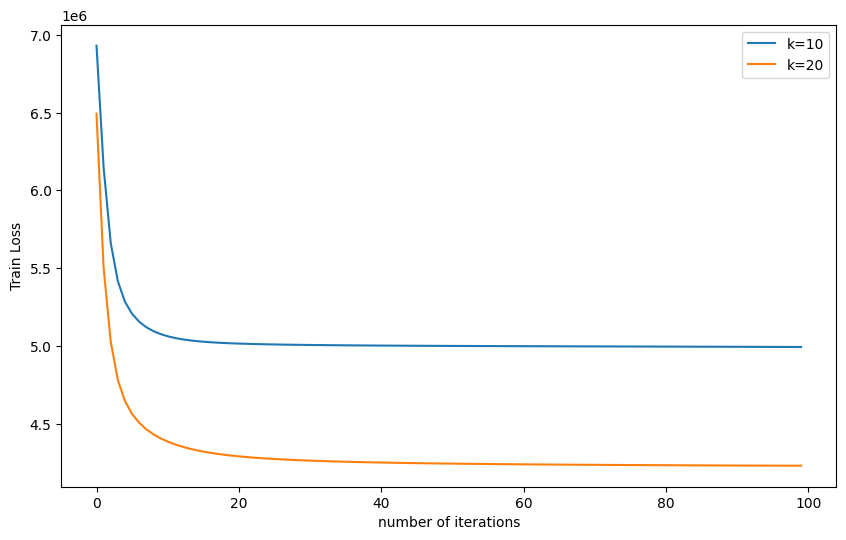

In [ ]:
# Create a plot
plt.figure(figsize=(10, 6))

# Plot each loss list
plt.plot(train_losses_k10, label='k=10')
plt.plot(train_losses_k20, label='k=20')


# Add titles and labels
# plt.title('Losses for Various Values of k')
plt.xlabel('number of iterations')
plt.ylabel('Train Loss')

# Add a legend
plt.legend()

# Show the plot
# plt.show()
filename = 'train_losses_for_various_k.pdf'
plt.savefig(filename, bbox_inches='tight')

236

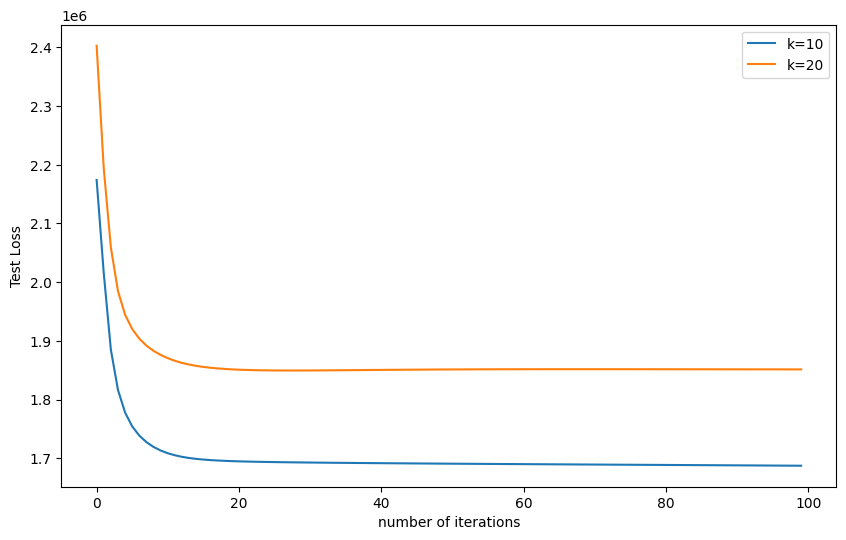

In [ ]:


# Create a plot
plt.figure(figsize=(10, 6))

# Plot each loss list
plt.plot(test_losses_k10, label='k=10')
plt.plot(test_losses_k20, label='k=20')


# Add titles and labels
# plt.title('Losses for Various Values of k')
plt.xlabel('number of iterations')
plt.ylabel('Test Loss')

# Add a legend
plt.legend()

# Show the plot
# plt.show()
filename = 'test_losses_for_various_k.pdf'
plt.savefig(filename, bbox_inches='tight')



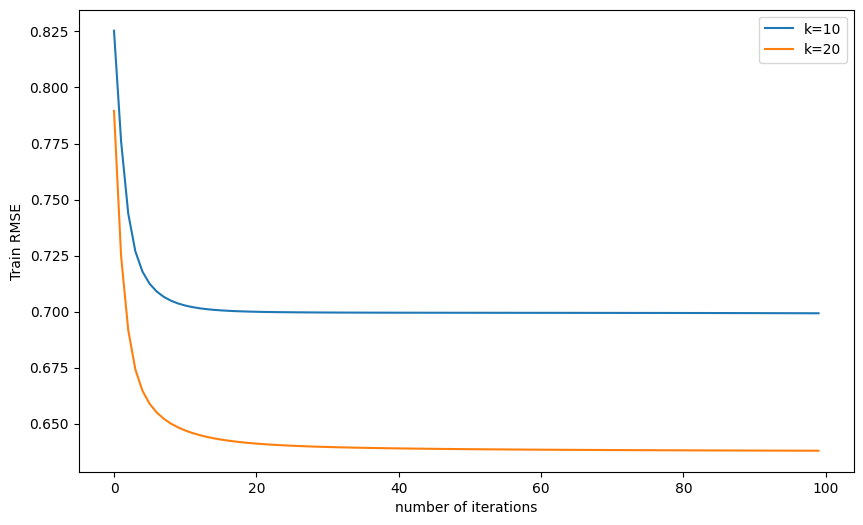

In [ ]:
# Create a plot
plt.figure(figsize=(10, 6))

# Plot each loss list
plt.plot(train_errors_k10, label='k=10')
plt.plot(train_errors_k20, label='k=20')

# Add titles and labels
# plt.title('Losses for Various Values of k')
plt.xlabel('number of iterations')
plt.ylabel('Train RMSE')

# Add a legend
plt.legend()

# Show the plot
# plt.show()
filename = 'Train_RMSE_for_various_k.pdf'
plt.savefig(filename, bbox_inches='tight')



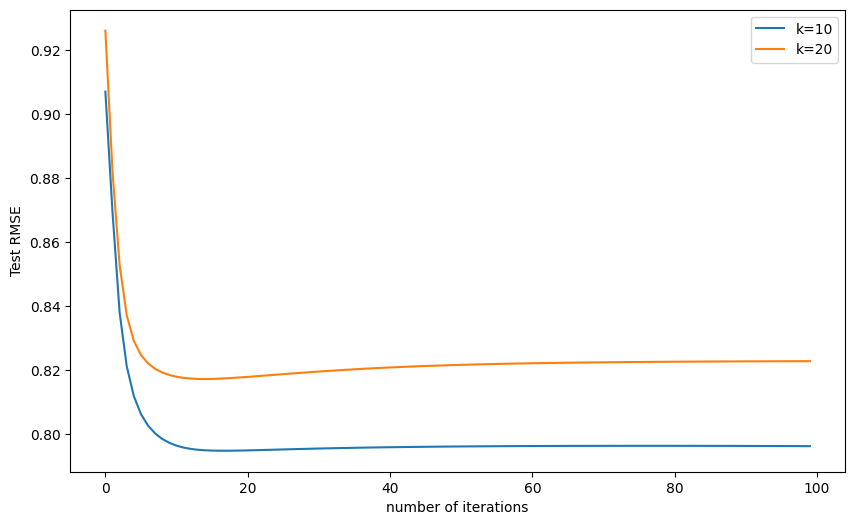

In [ ]:


# Create a plot
plt.figure(figsize=(10, 6))

# Plot each loss list
plt.plot(test_errors_k10, label='k=10')
plt.plot(test_errors_k20, label='k=20')

# Add titles and labels
# plt.title('Losses for Various Values of k')
plt.xlabel('number of iterations')
plt.ylabel('Test RMSE')

# Add a legend
plt.legend()

# Show the plot
# plt.show()
filename = 'Test_RMSE_for_various_k.pdf'
plt.savefig(filename, bbox_inches='tight')



In [ ]:
import pickle

with open('user_biases_k20.pkl', 'wb') as f:
    pickle.dump(user_biases, f)

with open('item_biases_k20.pkl', 'wb') as f:
    pickle.dump(item_biases, f)

with open('user_latent_vectors_k20.pkl', 'wb') as f:
    pickle.dump(user_latent_vectors, f)

with open('item_latent_vectors_k20.pkl', 'wb') as f:
    pickle.dump(item_latent_vectors, f)


## PREDICTION USING OUR BEST MODEL OF k=10 FOR THE UNDIVIDED DATASET

In [33]:
def train_new_user(user_list):
    k=10
    user_latent_vectors = np.zeros(k)
    user_list = np.array(user_list)
    num_iter=100
    lbda=0.01
    gamma = 0.001
    tau = 0.001
    for i in range(num_iter):
        ratings = user_list[:, 1]
        indices = user_list[:, 0].astype(int)

        user_bias = lbda * np.sum(ratings - np.einsum('i,ji->j', user_latent_vectors, item_latent_vectors[indices]) - item_biases[indices]) / (lbda * len(indices) + gamma)

        # Calculate left and right matrices for user factor update
        left = np.sum(np.einsum('ij,il->ijl', item_latent_vectors[indices], item_latent_vectors[indices]), axis=0)
        right = np.sum(np.einsum('ji,j->ji', item_latent_vectors[indices], ratings - user_bias - item_biases[indices]), axis=0)
        # Update user factor
        user_latent_vectors = np.linalg.solve(lbda * left + tau * np.eye(k), lbda * right)
        # print(user_latent_vectors, user_bias)
    return user_latent_vectors

In [34]:
# Create a quick helper function to search through the dataset by title and return the item/movie id and index
def search_movies(df, search_phrase):
    search_phrase = search_phrase.lower()
    filtered_df = df[df['title'].str.lower().str.contains(search_phrase)]
    return filtered_df[['title', 'movieId', 'movie_index']]

search_movies(movies_df, 'Lord of the Rings')

,title,movieId,movie_index
2026,"Lord of the Rings, The (1978)",2116,2189
4887,"Lord of the Rings: The Fellowship of the Ring,...",4993,202
5840,"Lord of the Rings: The Two Towers, The (2002)",5952,36
7028,"Lord of the Rings: The Return of the King, The...",7153,227


In [35]:
user_latent_vectors = train_new_user([(2189, 5)])

In [36]:
def get_top_predictions(user_latent_vectors, item_latent_vectors, item_biases, movie_data_list, movies_df, top_n=20, min_users_ratings=300):
    # Calculate movie scores
    movie_scores = np.einsum('i,ji->j', user_latent_vectors, item_latent_vectors) + 0.01*item_biases

    # Sort movie indices by scores
    movie_indices = np.argsort(movie_scores)[::-1]

    # Initialize a list to store top predictions
    top_predictions = []

    # Iterate through the sorted movie indices
    for index in movie_indices:
        # Check if the movie has at least min_users_ratings
        if len(movie_data_list[index]) >= min_users_ratings:
            # Append the movie title to top predictions
            top_predictions.append(movies_df.loc[movies_df['movie_index'] == index, 'title'].iloc[0])

            # Break the loop if we have enough top predictions
            if len(top_predictions) >= top_n:
                break

    return top_predictions


In [37]:
top_predictions = get_top_predictions(user_latent_vectors, item_latent_vectors, item_biases, movie_data_list, movies_df)


In [38]:
top_predictions

['Lord of the Rings: The Return of the King, The (2003)',
 'Lord of the Rings: The Two Towers, The (2002)',
 'Lord of the Rings: The Fellowship of the Ring, The (2001)',
 'Star Wars: Episode III - Revenge of the Sith (2005)',
 'Star Wars: Episode II - Attack of the Clones (2002)',
 'Lord of the Rings, The (1978)',
 'Hobbit: The Desolation of Smaug, The (2013)',
 'The Hobbit: The Battle of the Five Armies (2014)',
 'Dune (1984)',
 'Harry Potter and the Half-Blood Prince (2009)',
 'Harry Potter and the Deathly Hallows: Part 1 (2010)',
 'Harry Potter and the Deathly Hallows: Part 2 (2011)',
 'Harry Potter and the Order of the Phoenix (2007)',
 'Hobbit: An Unexpected Journey, The (2012)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Transformers: The Movie (1986)',
 'Harry Potter and the Goblet of Fire (2005)',
 'Evangelion: 2.0 You Can (Not) Advance (Evangerion shin gekijôban: Ha) (2009)',
 'Harry Potter and the Chamber of Secrets (2002)',
 'Star Wars: Episode VI - Return of the

## TRAINING WITH THE FEATURE EMBEDDINGS FROM THE GENRE AND VISUALIZING THE PROCESS

  0%|          | 0/20 [00:00<?, ?it/s]

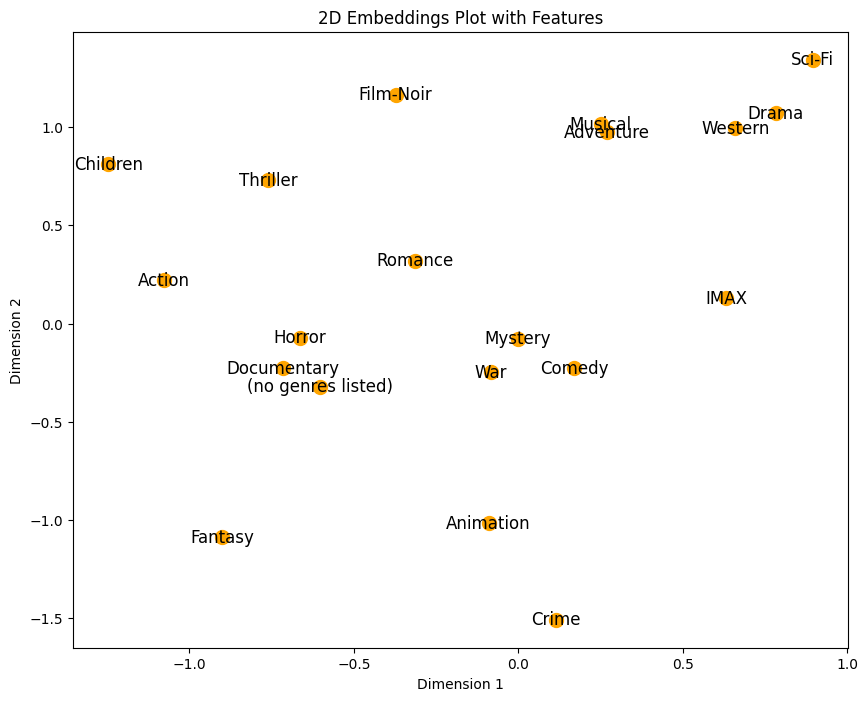

train rmse 0.8593719571245909 test rmse 0.8846413514445431


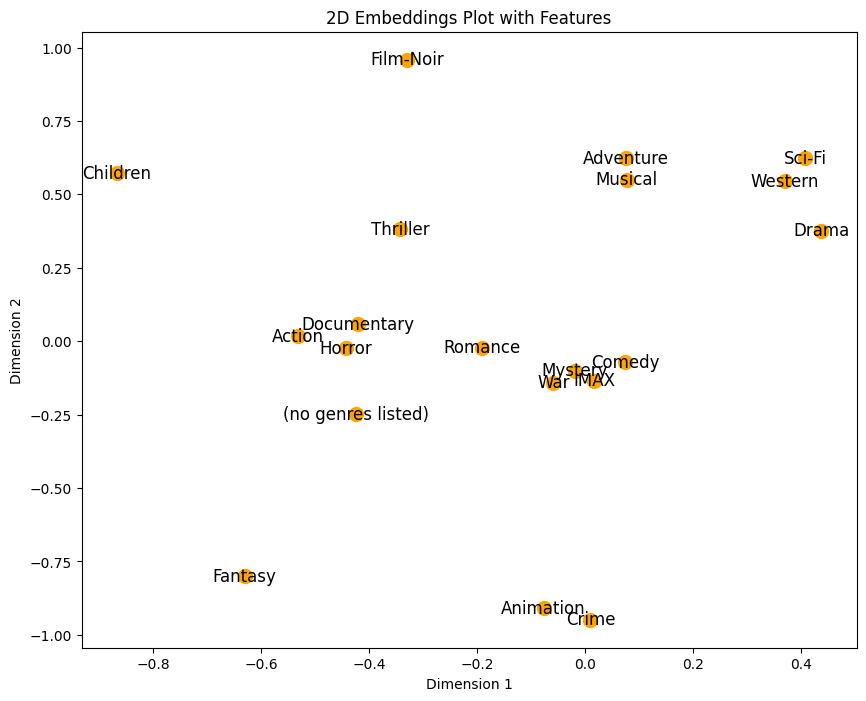

train rmse 0.8292917231852889 test rmse 0.8577386763710892


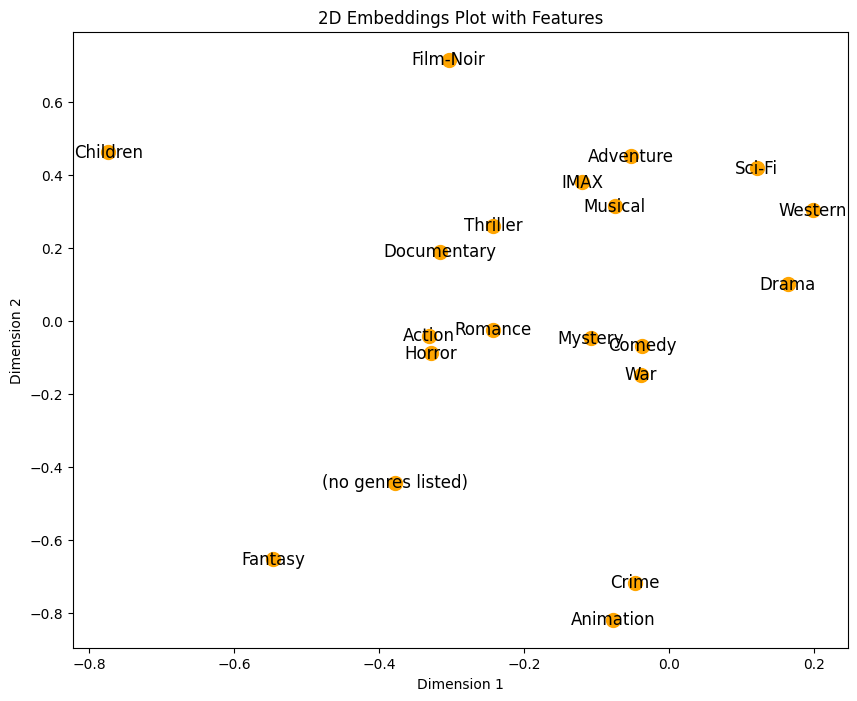

train rmse 0.8073636843758889 test rmse 0.8361053449063649


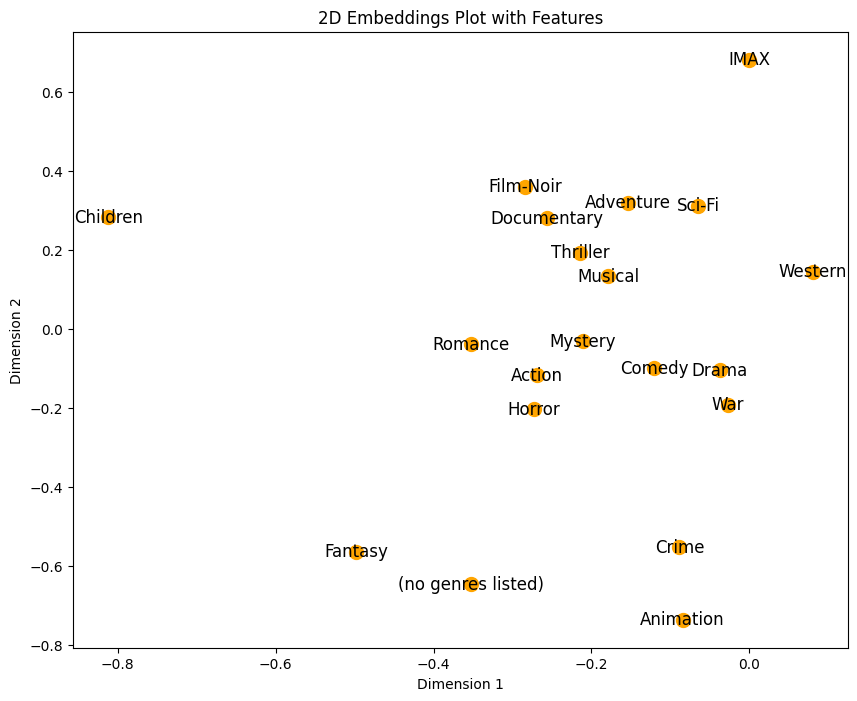

train rmse 0.7970198719878129 test rmse 0.8258540455647114


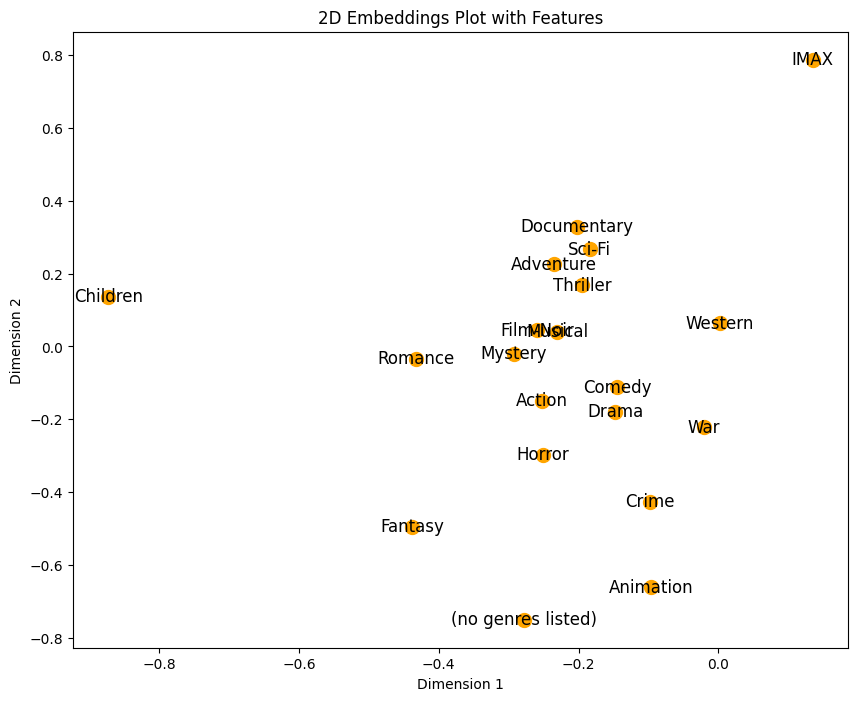

train rmse 0.7930971726052345 test rmse 0.8219266457550807


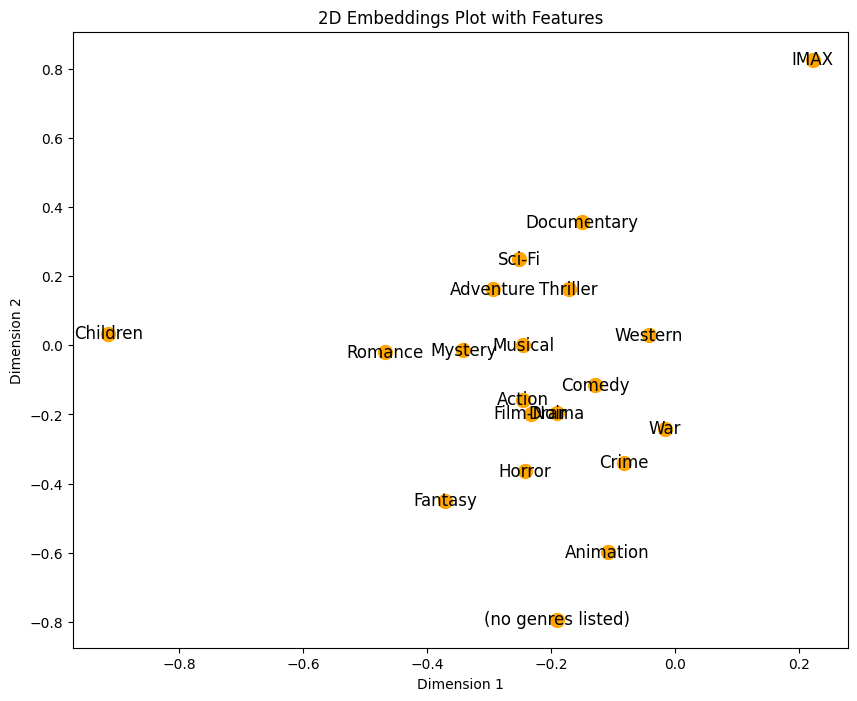

train rmse 0.7914486501344786 test rmse 0.8203156562305352


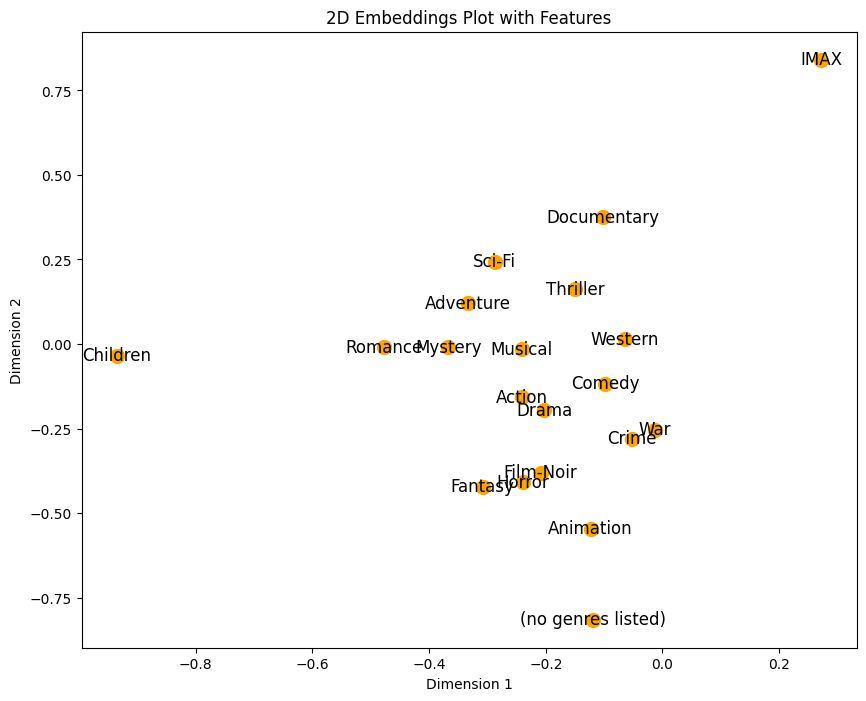

train rmse 0.790645663318472 test rmse 0.8195826179934325


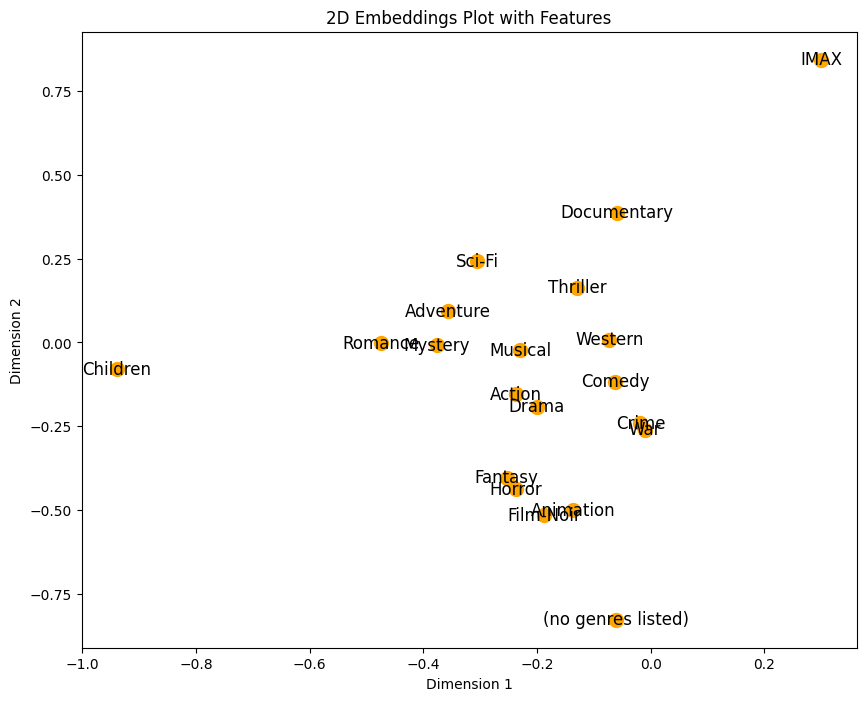

train rmse 0.7901906464806414 test rmse 0.8192050509330728


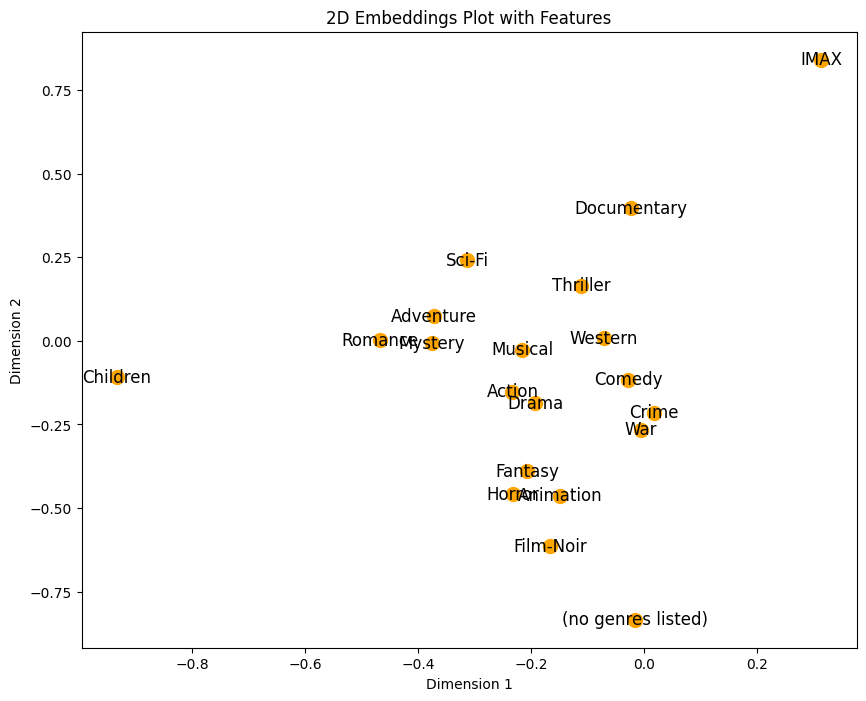

train rmse 0.789899469935109 test rmse 0.8189858122369335


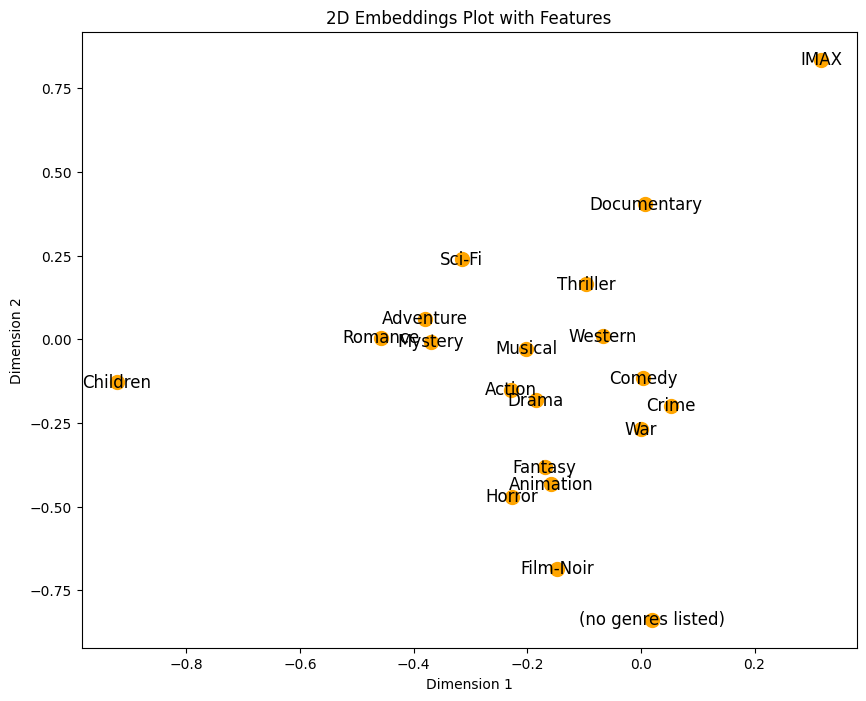

train rmse 0.789696250066844 test rmse 0.8188452681152322


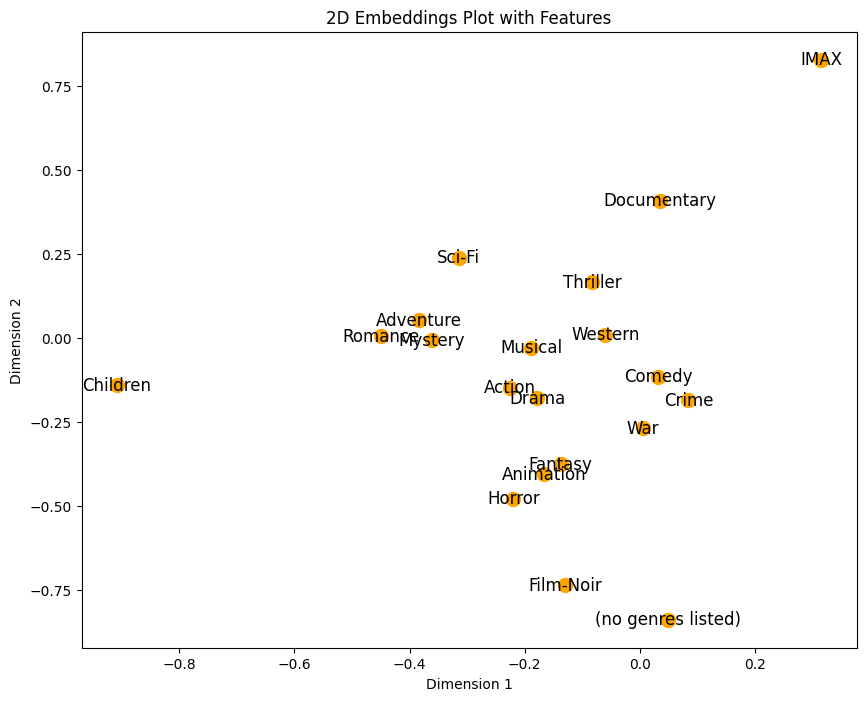

train rmse 0.7895455426100579 test rmse 0.8187477685662665


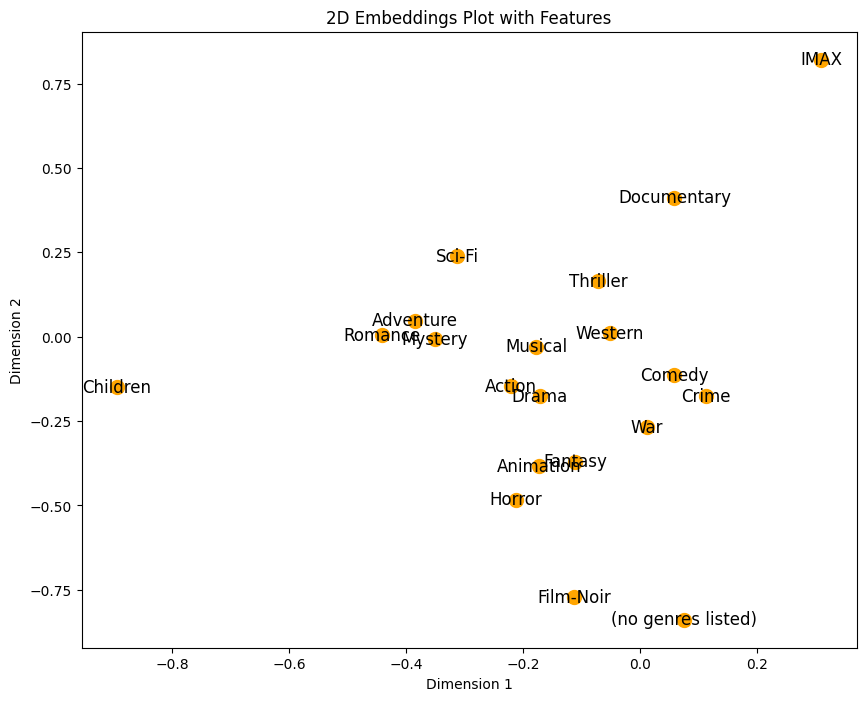

train rmse 0.7894288440742447 test rmse 0.8186759659888979


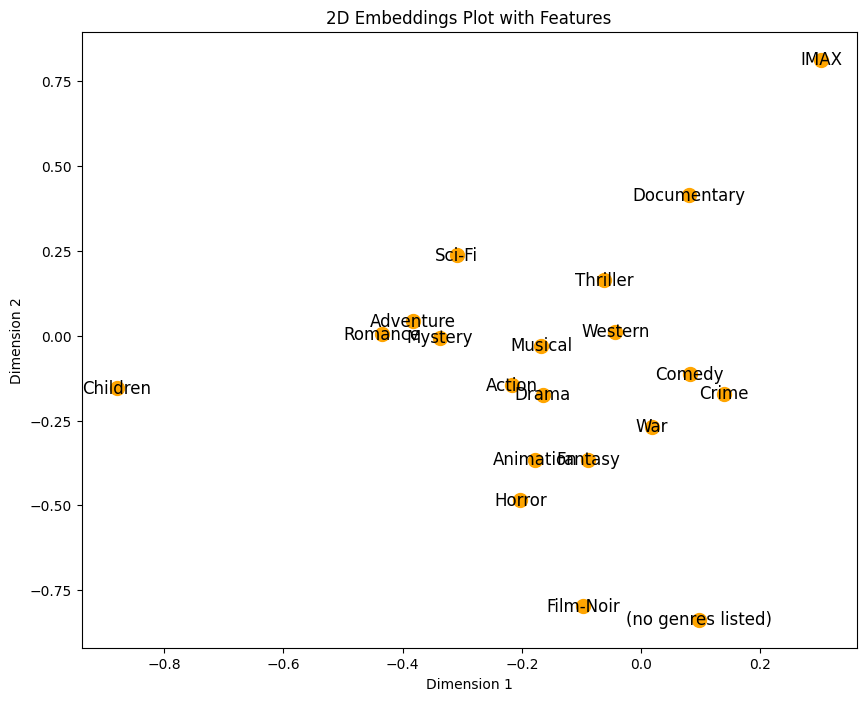

train rmse 0.7893355490096643 test rmse 0.8186207325475235


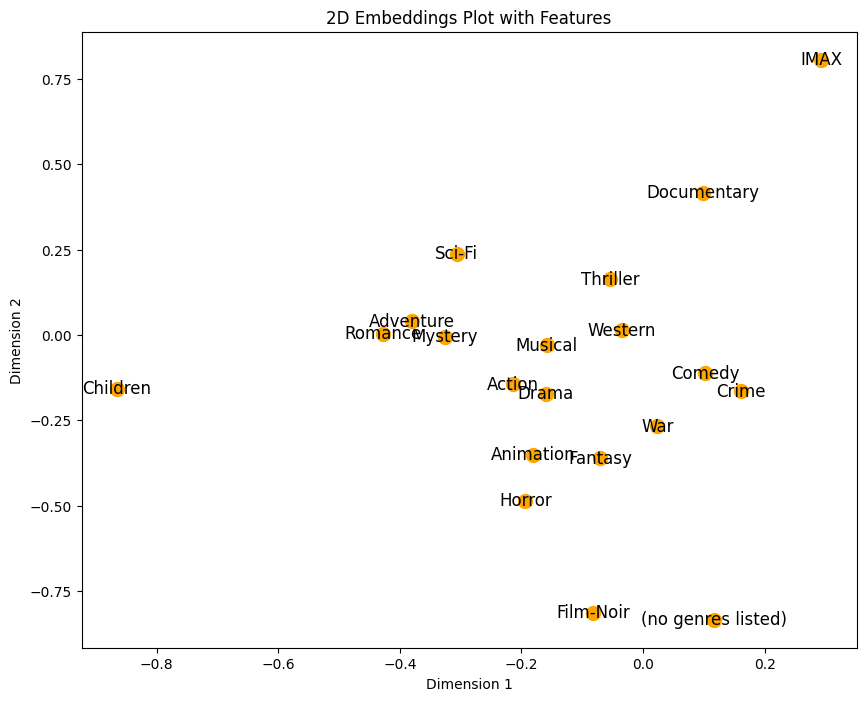

train rmse 0.7892590762074649 test rmse 0.8185768969191327


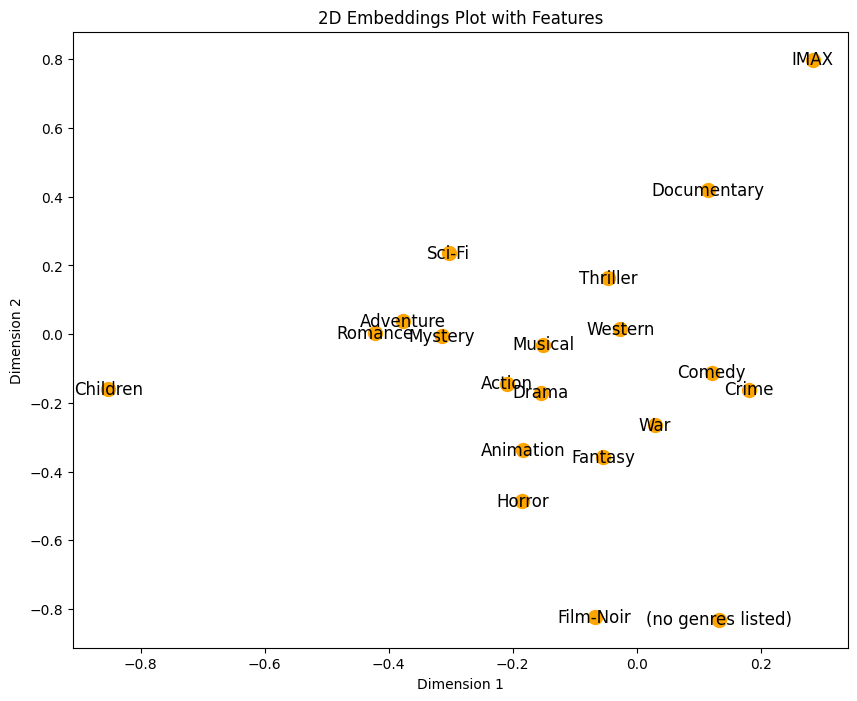

train rmse 0.78919507916331 test rmse 0.8185413040119911


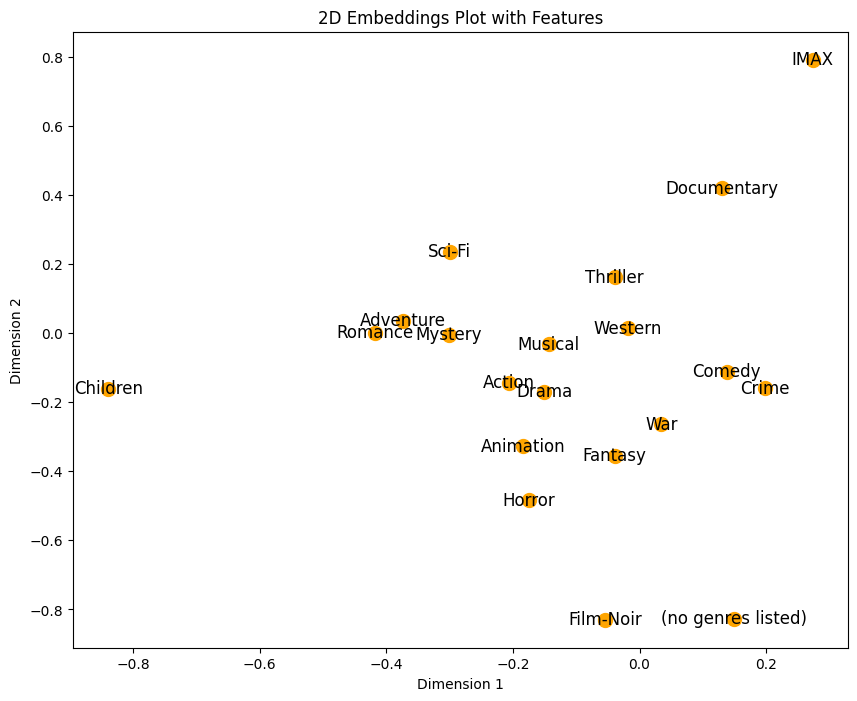

train rmse 0.7891405459825851 test rmse 0.8185118232417344


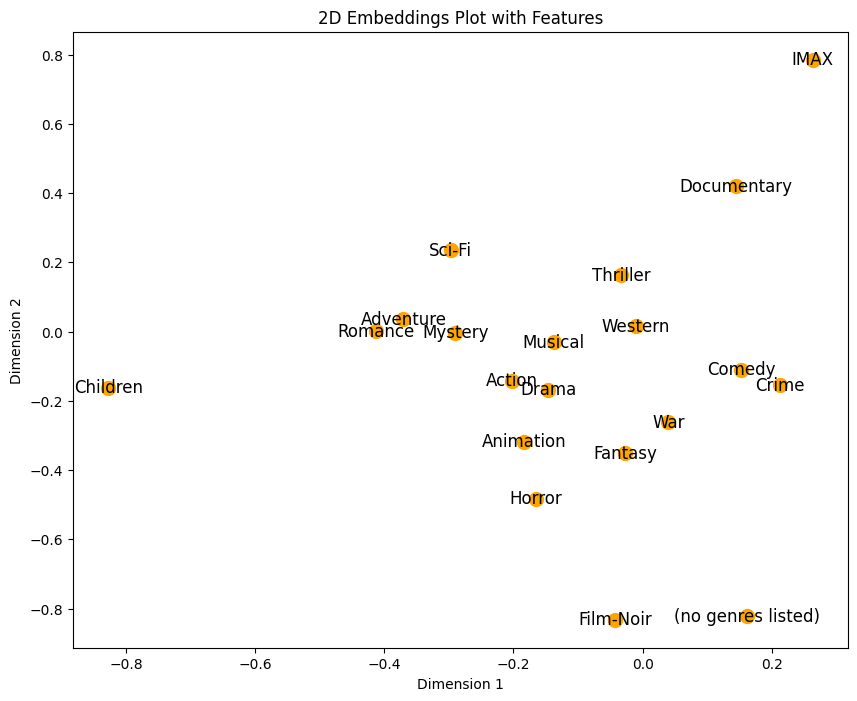

train rmse 0.7890934467616979 test rmse 0.8184868704954458


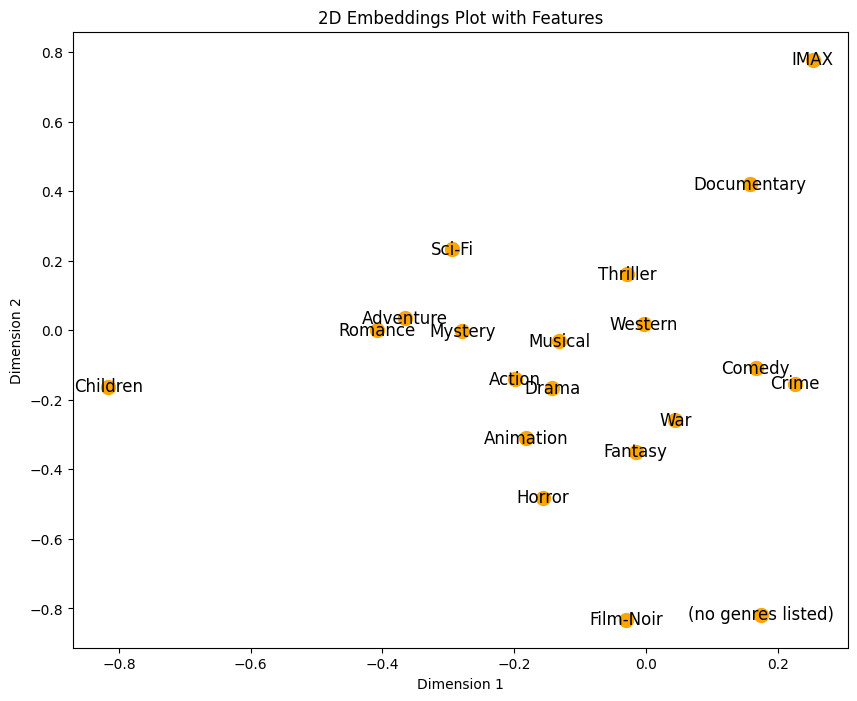

train rmse 0.7890524448468428 test rmse 0.8184655035094256


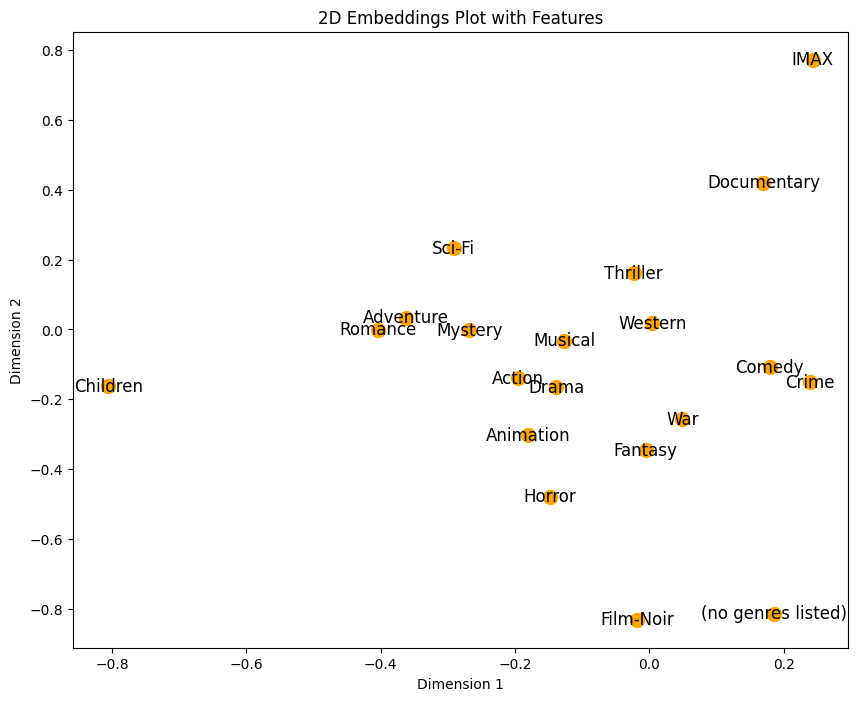

train rmse 0.7890165789966772 test rmse 0.8184472934670793


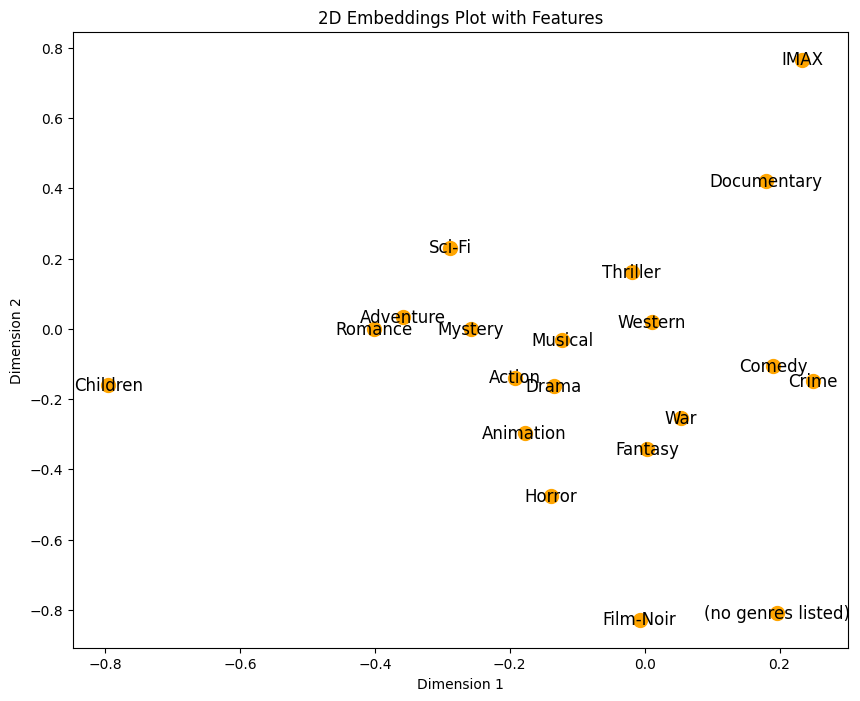

train rmse 0.7889850402065304 test rmse 0.8184318925347188


In [ ]:
from tqdm.notebook import tqdm

M = len(train_user_data_list)
N = len(train_movie_data_list)
k=2
user_biases = np.zeros((M))
num_features = len(index_to_features[0])
f_l = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(num_features, k))
item_biases = np.zeros((N))
user_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(M,k))
item_latent_vectors = np.random.normal(loc=0, scale=1/np.sqrt(k), size=(N,k))
train_losses=[]
test_losses=[]
train_errors=[]
test_errors=[]
iter = 20
lbda = 5
gamma = 0.1
tau = 1
genres = ['Drama', 'Fantasy', 'Mystery', 'Romance', 'Action', 'Animation', 'Sci-Fi', 'Thriller', 'Musical', 'Documentary', 'Film-Noir', 'Western', 'Comedy', 'Horror', 'Children', 'Crime', '(no genres listed)', 'War', 'Adventure', 'IMAX']




for i in tqdm(range(iter)):
    # Plot the embeddings
    plt.figure(figsize=(10,8))
    plt.scatter(f_l[:,0], f_l[:,1], s=100, c='orange')

    # Add genre labels to each point
    for j, genre in enumerate(genres):
        plt.text(f_l[j,0], f_l[j,1], genre, fontsize=12, ha='center', va='center')
    plt.title('2D Embeddings Plot with Features')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

    for m in range(M):
        # Extract ratings and indices for the current user
        if len(train_user_data_list) > 0:
            ratings = train_user_data_list[m][:, 1]
            indices = train_user_data_list[m][:, 0].astype(int)

            # Calculate user bias
            user_bias = lbda * np.sum(ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[indices]) - item_biases[indices]) / (lbda * len(indices) + gamma)
            user_biases[m] = user_bias

            # Calculate left and right matrices for user factor update
            left = np.sum(np.einsum('ij,il->ijl', item_latent_vectors[indices], item_latent_vectors[indices]), axis=0)
            right = np.sum(np.einsum('ji,j->ji', item_latent_vectors[indices], ratings - user_bias - item_biases[indices]), axis=0)

            # Update user factor
            user_latent_vectors[m] = np.linalg.solve(lbda * left + tau * np.eye(k), lbda * right)

    for n in range(N):
        # Extract ratings and indices for the current item
        if len(train_movie_data_list[n]) > 0:
            ratings = train_movie_data_list[n][:, 1]
            indices = train_movie_data_list[n][:, 0].astype(int)

            # Calculate item bias
            item_bias = lbda * np.sum(ratings - np.einsum('ij,j->i', user_latent_vectors[indices], item_latent_vectors[n]) - user_biases[indices]) / (lbda * len(indices) + gamma)
            item_biases[n] = item_bias

            # Calculate left and right matrices for item factor update
            left = np.sum(np.einsum('ij,il->ijl', user_latent_vectors[indices], user_latent_vectors[indices]), axis=0)
            right = np.sum(np.einsum('ji,j->ji', user_latent_vectors[indices], ratings - user_biases[indices] - item_bias), axis=0)

            F_n = np.sum(index_to_features[n])
            # Update item factor
            item_latent_vectors[n] = np.linalg.solve(left + tau * np.eye(k), right + tau * (np.dot(index_to_features[n], f_l[:]) / np.sqrt(F_n)))

    for i in range(num_features):
        indices = np.where(feature_vectors[:, i] == 1) # get movies with ith feature
        feature_sums = np.sum(feature_vectors[indices], axis=1) # get number of features for movies containing ith feature
        features_except_i = np.delete(feature_vectors, i, axis=1)[indices] # get other features except ith feature for movies with ith feature
        F_except_i = np.delete(f_l, i, axis=0) # get feature embeddings for other features except ith feature

        total_right = np.sum(np.einsum('ij, i -> ij', item_latent_vectors[indices], 1/np.sqrt(feature_sums))
                             - np.einsum('i, ij-> ij', 1/feature_sums , np.einsum('ij, jk -> ik', features_except_i, F_except_i)), axis=0) # calculate feature update

        f_l[i] = total_right/(np.sum(1/np.sqrt(feature_sums)) - 1)

    # Calculate training loss and RMSE
    train_error_squared = 0
    train_size = 0
    test_error_squared = 0
    test_size = 0

    for m in range(M):
        if len(train_user_data_list[m]) > 0:
            train_ratings = train_user_data_list[m][:, 1]
            train_indices = train_user_data_list[m][:, 0].astype(int)
            train_error_squared += np.sum((train_ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[train_indices]) - user_biases[m] - item_biases[train_indices])**2)
            train_size += len(train_indices)

        if len(test_user_data_list[m]) > 0:
            test_ratings = test_user_data_list[m][:, 1]
            test_indices = test_user_data_list[m][:, 0].astype(int)
            test_error_squared += np.sum((test_ratings - np.einsum('i,ji->j', user_latent_vectors[m], item_latent_vectors[test_indices]) - user_biases[m] - item_biases[test_indices])**2)
            test_size += len(test_indices)

    # train_loss = -0.5 * lbda * train_error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij,ij->', item_latent_vectors, item_latent_vectors) + np.einsum('ij,ij->', user_latent_vectors, user_latent_vectors))
    train_error = np.sqrt(1 / train_size * train_error_squared)

    # train_losses.append(-train_loss)
    train_errors.append(train_error)

    # test_loss = -0.5 * lbda * test_error_squared - 0.5 * gamma * np.sum(user_biases**2) - 0.5 * gamma * np.sum(item_biases**2) - 0.5 * tau * (np.einsum('ij, ij->', item_latent_vectors, item_latent_vectors) + np.einsum('ij, ij->', user_latent_vectors, user_latent_vectors))
    test_error = np.sqrt(1/test_size * test_error_squared)

    # test_losses.append(-test_loss)
    test_errors.append(test_error)

    print(f"train rmse {train_error} test rmse {test_error}")



## BAYESIAN PERSONALIZED RANKING (BPR) IMPLEMENTATION

In [40]:
# Convert explicit ratings to implicit feedback
# ratings_df['implicit_feedback'] = ratings_df['rating'].apply(lambda x: 1 if x > 3 else 0)
# df = ratings_df[['userId', 'movie_index', 'user_index', 'movieId', 'implicit_feedback']]
df = ratings_df[['userId', 'movie_index', 'user_index', 'movieId', 'rating']]
df.head()

,userId,movie_index,user_index,movieId,rating
0,1,0,0,296,5.0
1,1,1,0,306,3.5
2,1,2,0,307,5.0
3,1,3,0,665,5.0
4,1,4,0,899,3.5


In [45]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.special import expit  # Sigmoid function

class BPR:
    def __init__(self, num_users, num_items, latent_dim=10, learning_rate=0.01, reg=0.1):
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.reg = reg
        self.user_factors = np.random.normal(0, 1/np.sqrt(latent_dim), (num_users, latent_dim))
        self.item_factors = np.random.normal(0, 1/np.sqrt(latent_dim), (num_items, latent_dim))

    def sample_triplet(self, user_item_matrix):
        user = np.random.choice(user_item_matrix.shape[0])
        positive_item = np.random.choice(user_item_matrix.indices[user_item_matrix.indptr[user]:user_item_matrix.indptr[user + 1]])
        negative_item = np.random.choice(np.setdiff1d(np.arange(self.num_items), user_item_matrix.indices[user_item_matrix.indptr[user]:user_item_matrix.indptr[user + 1]]))
        return user, positive_item, negative_item
ipynb
    def train(self, user_item_matrix, num_epochs=5):
        for epoch in range(num_epochs):
            for _ in range(5*user_item_matrix.shape[0]):  # Number of samples per epoch
                u, i, j = self.sample_triplet(user_item_matrix)
                x_uij = np.dot(self.user_factors[u], self.item_factors[i]) - np.dot(self.user_factors[u], self.item_factors[j])
                sigmoid_x_uij = expit(x_uij)
                # sigmoid_x_uij = np.exp(-x_uij) / (1 + np.exp(-x_uij))
                grad_user = (sigmoid_x_uij * (self.item_factors[i] - self.item_factors[j])) + (self.reg * self.user_factors[u])
                grad_item_i = (sigmoid_x_uij * self.user_factors[u]) + (self.reg * self.item_factors[i])
                grad_item_j = (-sigmoid_x_uij * self.user_factors[u]) + (self.reg * self.item_factors[j])
                self.user_factors[u] += self.learning_rate * grad_user
                self.item_factors[i] += self.learning_rate * grad_item_i
                self.item_factors[j] += self.learning_rate * grad_item_j
            print(f"Epoch {epoch + 1}/{num_epochs} completed")

    def predict(self, user, item):
        return np.dot(self.user_factors[user], self.item_factors[item])

# Precision@K and Recall@K functions
def precision_at_k(predictions, ground_truth, k):
    relevant = set(ground_truth)
    recommended = set(predictions[:k])
    return len(relevant & recommended) / k

def recall_at_k(predictions, ground_truth, k):
    relevant = set(ground_truth)
    recommended = set(predictions[:k])
    return len(relevant & recommended) / len(relevant)


# Create a sparse matrix
num_users = df['user_index'].max() + 1
num_items = df['movie_index'].max() + 1
data = df['rating'].values
row = df['user_index'].values
col = df['movie_index'].values
user_item_matrix = csr_matrix((data, (row, col)), shape=(num_users, num_items))


bpr = BPR(num_users, num_items)
bpr.train(user_item_matrix, num_epochs=10)

# Example evaluation
user = 0
predictions = np.argsort([bpr.predict(user, item) for item in range(num_items)])[::-1]
ground_truth = df[df['user_index'] == user]['movie_index'].values

precision_k = precision_at_k(predictions, ground_truth, k=4)
recall_k = recall_at_k(predictions, ground_truth, k=4)

print(f"Precision@K: {precision_k}, Recall@K: {recall_k}")


Epoch 1/10 completed
Epoch 2/10 completed
Epoch 3/10 completed
Epoch 4/10 completed
Epoch 5/10 completed
Epoch 6/10 completed
Epoch 7/10 completed
Epoch 8/10 completed
Epoch 9/10 completed
Epoch 10/10 completed
Precision@K: 0.0, Recall@K: 0.0


In [ ]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.special import expit  # Sigmoid function

class BPR:
    def __init__(self, num_users, num_items, latent_dim=10, learning_rate=0.01, reg=0.1):
        self.num_users = num_users
        self.num_items = num_items
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate
        self.reg = reg
        self.user_factors = np.random.normal(0, 1/np.sqrt(latent_dim), (num_users, latent_dim))
        self.item_factors = np.random.normal(0, 1/np.sqrt(latent_dim), (num_items, latent_dim))

    def sample_triplet(self, user, user_item_matrix):
        # user = np.random.choice(user_item_matrix.shape[0])
        positive_item = np.random.choice(user_item_matrix.indices[user_item_matrix.indptr[user]:user_item_matrix.indptr[user + 1]])
        negative_item = np.random.choice(np.setdiff1d(np.arange(self.num_items), user_item_matrix.indices[user_item_matrix.indptr[user]:user_item_matrix.indptr[user + 1]]))
        return user, positive_item, negative_item

    def train(self, user_item_matrix, num_epochs=10):
        for epoch in range(num_epochs):
            for user in range(user_item_matrix.shape[0]):  # Number of samples per epoch
                u, i, j = self.sample_triplet(user, user_item_matrix)
                x_uij = np.dot(self.user_factors[u], self.item_factors[i]) - np.dot(self.user_factors[u], self.item_factors[j])
                sigmoid_x_uij = expit(x_uij)
                # sigmoid_x_uij = np.exp(-x_uij) / (1 + np.exp(-x_uij))
                grad_user = (sigmoid_x_uij * (self.item_factors[i] - self.item_factors[j])) + (self.reg * self.user_factors[u])
                grad_item_i = (sigmoid_x_uij * self.user_factors[u]) + (self.reg * self.item_factors[i])
                grad_item_j = (-sigmoid_x_uij * self.user_factors[u]) + (self.reg * self.item_factors[j])
                self.user_factors[u] += self.learning_rate * grad_user
                self.item_factors[i] += self.learning_rate * grad_item_i
                self.item_factors[j] += self.learning_rate * grad_item_j
            print(f"Epoch {epoch + 1}/{num_epochs} completed")

    def predict(self, user, item):
        return np.dot(self.user_factors[user], self.item_factors[item])

# Precision@K and Recall@K functions
def precision_at_k(predictions, ground_truth, k):
    relevant = set(ground_truth)
    recommended = set(predictions[:k])
    return len(relevant & recommended) / k

def recall_at_k(predictions, ground_truth, k):
    relevant = set(ground_truth)
    recommended = set(predictions[:k])
    return len(relevant & recommended) / len(relevant)

# Function to evaluate precision@k and recall@k for all users
def evaluate_bpr(bpr, user_item_matrix, k):
    precision_at_k_list = []
    recall_at_k_list = []

    for user in range(user_item_matrix.shape[0]):
        predictions = np.argsort([bpr.predict(user, item) for item in range(bpr.num_items)])[::-1]
        ground_truth = user_item_matrix.indices[user_item_matrix.indptr[user]:user_item_matrix.indptr[user + 1]]

        precision_k = precision_at_k(predictions, ground_truth, k)
        recall_k = recall_at_k(predictions, ground_truth, k)

        precision_at_k_list.append(precision_k)
        recall_at_k_list.append(recall_k)

    avg_precision_at_k = np.mean(precision_at_k_list)
    avg_recall_at_k = np.mean(recall_at_k_list)

    return avg_precision_at_k, avg_recall_at_k


Create a sparse matrix
num_users = df['user_index'].max() + 1
num_items = df['movie_index'].max() + 1
data = df['implicit_feedback'].values
row = df['user_index'].values
col = df['movie_index'].values
user_item_matrix = csr_matrix((data, (row, col)), shape=(num_users, num_items))



# Train the BPR model
bpr = BPR(num_users, num_items)
bpr.train(user_item_matrix, num_epochs=10)

# Evaluate the model
precision_k, recall_k = evaluate_bpr(bpr, user_item_matrix, k=4)

print(f"Average Precision@K: {precision_k}, Average Recall@K: {recall_k}")





# bpr = BPR(num_users, num_items)
# bpr.train(user_item_matrix, num_epochs=10)

# # Example evaluation
# user = 0
# predictions = np.argsort([bpr.predict(user, item) for item in range(num_items)])[::-1]
# ground_truth = df[df['user_index'] == user]['movie_index'].values

# precision_k = precision_at_k(predictions, ground_truth, k=4)
# recall_k = recall_at_k(predictions, ground_truth, k=4)

# print(f"Precision@K: {precision_k}, Recall@K: {recall_k}")


In [ ]:
# Precision@K and Recall@K functions
def precision_at_k(predictions, ground_truth, k):
    relevant = set(ground_truth)
    recommended = set(predictions[:k])
    return len(relevant & recommended) / k

def recall_at_k(predictions, ground_truth, k):
    relevant = set(ground_truth)
    recommended = set(predictions[:k])
    return len(relevant & recommended) / len(relevant)

# Function to evaluate precision@k and recall@k for all users
def evaluate_bpr(bpr, user_item_matrix, k):
    precision_at_k_list = []
    recall_at_k_list = []

    for user in range(user_item_matrix.shape[0]):
        predictions = np.argsort([bpr.predict(user, item) for item in range(bpr.num_items)])[::-1]
        ground_truth = user_item_matrix.indices[user_item_matrix.indptr[user]:user_item_matrix.indptr[user + 1]]

        precision_k = precision_at_k(predictions, ground_truth, k)
        recall_k = recall_at_k(predictions, ground_truth, k)

        precision_at_k_list.append(precision_k)
        recall_at_k_list.append(recall_k)

    avg_precision_at_k = np.mean(precision_at_k_list)
    avg_recall_at_k = np.mean(recall_at_k_list)

    return avg_precision_at_k, avg_recall_at_k


# Create a sparse matrix
num_users = df['user_index'].max() + 1
num_items = df['movie_index'].max() + 1
data = df['implicit_feedback'].values
row = df['user_index'].values
col = df['movie_index'].values
user_item_matrix = csr_matrix((data, (row, col)), shape=(num_users, num_items))

# Train the BPR model
bpr = BPR(num_users, num_items)
# bpr.train(user_item_matrix, num_epochs=10)

# Evaluate the model
precision_k, recall_k = evaluate_bpr(bpr, user_item_matrix, k=4)

print(f"Average Precision@K: {precision_k}, Average Recall@K: {recall_k}")

Average Precision@K: 0.002014876246608548, Average Recall@K: 4.886087319081353e-05
